In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
from dash.dependencies import Input, Output, State
import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from dash import dash_table,dcc, html
import plotly.graph_objects as go


In [2]:
coord_paris = pd.read_csv('coordinates_paris.csv')
coord_toulouse = pd.read_csv('coordinates_toulouse.csv')
xhour_paris = pd.read_csv('X_hour_paris.csv')
xhour_toulouse = pd.read_csv('X_hour_toulouse.csv')
distance_paris = pd.read_csv('distance_paris.csv')
distance_toulouse = pd.read_csv('distance_toulouse.csv')

In [3]:
coord_paris = coord_paris.rename(columns={
    'Unnamed: 0': 'nom_station',
})
coord_toulouse = coord_toulouse.rename(columns={
    'Unnamed: 0': 'nom_station',
})
xhour_paris = xhour_paris.rename(columns={
    'Unnamed: 0': 'Heures',
})
xhour_toulouse = xhour_toulouse.rename(columns={
    'Unnamed: 0': 'Heures',
})

In [4]:
xhour_paris_long = xhour_paris.melt(id_vars=['Heures'], var_name='nom_station', value_name='taux_remplissage')
xhour_toulouse_long = xhour_toulouse.melt(id_vars=['Heures'], var_name='nom_station', value_name='taux_remplissage')


In [5]:
data_paris = pd.merge(xhour_paris_long, coord_paris, on='nom_station')
data_toulouse = pd.merge(xhour_toulouse_long, coord_toulouse, on='nom_station')

In [6]:
data_paris['jour'] = data_paris['Heures'] // 24 + 1
data_paris['semaine'] = data_paris['jour'] // 7 + 1 
data_paris['mois'] = data_paris['jour'] // 30 + 1

In [7]:
data_paris['jour'] = data_paris['jour'] % 7
data_paris['jour'] = data_paris['jour'].replace(0, 7)

In [8]:
data_paris.head()

,Heures,nom_station,taux_remplissage,latitude,longitude,jour,semaine,mois
0,1,00906-gare-de-lest,0.05,48.87642,2.35863,1,1,1
1,2,00906-gare-de-lest,0.00,48.87642,2.35863,1,1,1
2,3,00906-gare-de-lest,0.00,48.87642,2.35863,1,1,1
3,4,00906-gare-de-lest,0.00,48.87642,2.35863,1,1,1
4,5,00906-gare-de-lest,0.00,48.87642,2.35863,1,1,1


- Des packages qui permet d avoir des tableaux de bords
- mise en forme graphique de calcul de stati descriptives
- dashboard
- Vecteur de 24 h qui contient les valeurs pour chaque station chaque jour (185 vecteurs pour chaque station)

In [9]:
xhour_paris.head()

,Heures,00906-gare-de-lest,01001-ile-de-la-cite-pont-neuf,01007-etienne-marcel,01019-saint-honore-vendome,02004-reaumur-montorgueil,02012-quatre-septembre,05006-saint-jacques-soufflot,05009-square-viviani,05012-ulm-lhomond,...,42701-gide-le-kremlin-bicetre,42702-leclerc-kremlin-bicetre,42706-salengro-kremlin-bicetre,43001-paris-1-vincennes,43002-lagny-vincennes,43004-montreuil-vincennes,43006-minimes-vincennes,43007-vorges-vincennes,44101-place-mongolfier-saint-maurice,44102-verdun-saint-maurice
0,1,0.05,0.6875,0.5,0.214286,0.823529,0.095238,0.000000,0.875,0.0,...,0.066667,0.05,0.566667,0.283560,0.68,0.76,0.714286,1.0,0.604167,1.0
1,2,0.00,0.6875,0.2,0.214286,0.941176,0.095238,0.000000,0.500,0.0,...,0.066667,0.05,0.533333,0.272727,0.72,0.72,0.714286,1.0,0.604167,1.0
2,3,0.00,0.6875,0.2,0.214286,0.941176,0.095238,0.076923,0.500,0.0,...,0.066667,0.05,0.500000,0.272727,0.76,0.80,0.714286,1.0,0.604167,1.0
3,4,0.00,0.6875,0.2,0.214286,1.000000,0.095238,0.000000,0.500,0.0,...,0.066667,0.05,0.500000,0.272727,0.76,0.80,0.714286,1.0,0.604167,1.0
4,5,0.00,0.6875,0.2,0.214286,1.000000,0.095238,0.000000,0.500,0.0,...,0.066667,0.05,0.500000,0.272727,0.76,0.80,0.714286,1.0,0.604167,1.0


In [10]:
xhour_paris['jour'] = (xhour_paris['Heures'] - 1) // 24 + 1  # Jour 1, Jour 2, ..., Jour 184

In [11]:
rows = []
# Boucler sur chaque jour
for jour, groupe in xhour_paris.groupby('jour'):
    # Créer un dictionnaire pour stocker les données du jour
    row = {'jour': jour}
    
    # Pour chaque station, extraire les 24 heures de taux de remplissage
    for station in xhour_paris.columns[1:-1]:  # Ignorer 'heure' et 'jour'
        row[station] = groupe[station].values  # Prendre les 24 valeurs du jour
    rows.append(row)
    # Ajouter cette ligne au nouveau DataFrame
    xjour_paris = pd.DataFrame(rows)

Création d'un tableau de Vecteurs Pour manipuler les données :

In [12]:
xjour_paris.tail()

,jour,00906-gare-de-lest,01001-ile-de-la-cite-pont-neuf,01007-etienne-marcel,01019-saint-honore-vendome,02004-reaumur-montorgueil,02012-quatre-septembre,05006-saint-jacques-soufflot,05009-square-viviani,05012-ulm-lhomond,...,42701-gide-le-kremlin-bicetre,42702-leclerc-kremlin-bicetre,42706-salengro-kremlin-bicetre,43001-paris-1-vincennes,43002-lagny-vincennes,43004-montreuil-vincennes,43006-minimes-vincennes,43007-vorges-vincennes,44101-place-mongolfier-saint-maurice,44102-verdun-saint-maurice
180,181,"[0.199152285832957, 0.162084740528179, 0.15, 0...","[0.871475954103171, 0.8125, 0.800080619615311,...","[0.65, 0.5, 0.457207064567209, 0.45, 0.4684104...","[0.152871778201218, 0.142857142857143, 0.19904...","[0.510135174254356, 0.0, 0.0, 0.05882352941176...","[0.0, 0.0923180674861993, 0.0341138607694201, ...","[0.0, 0.049476317225521, 0.194051185567323, 0....","[0.875, 0.953423306911622, 0.787623531668054, ...","[0.0, 0.0, 0.0, 0.0491258923655027, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.05, 0.05, 0.05, 0.0160559281448717, 0.0, 0....","[0.0540104974144576, 0.1, 0.233333333333333, 0...","[0.455190447857222, 0.454545454545455, 0.5, 0....","[0.199940106347787, 0.35877002264374, 0.501281...","[0.886633333343109, 0.88, 0.88, 0.96, 0.96, 0....","[0.428571428571429, 0.464285714285714, 0.5, 0....","[0.28, 0.28, 0.252990757431231, 0.294038589207...","[0.791666666666667, 0.791666666666667, 0.79166...","[0.844201649999516, 0.862201649999516, 0.88, 0..."
181,182,"[0.0523389502789167, 0.0, 0.0, 0.0, 0.0, 0.006...","[0.680660282278971, 0.394719955471665, 0.15231...","[1.0, 0.6, 0.55, 0.20458872306746, 0.2, 0.2, 0...","[0.888718731285954, 0.882784549199475, 0.85714...","[0.886870842192199, 0.881922929693857, 0.83088...","[0.595238095238095, 0.595238095238095, 0.61600...","[0.914683355599577, 0.808409508560116, 0.70213...","[0.924302705241436, 0.27131763061457, 0.089595...","[0.126721404742194, 0.252824528623484, 0.21205...",...,"[0.0333333333333333, 0.0333333333333333, 0.033...","[0.04885761390984, 0.0128863908882572, 0.0, 0....","[0.0075021683878687, 0.0, 0.0, 0.0333333333333...","[0.0, 0.0517727272633672, 0.0909090909090909, ...","[0.15237980930798, 0.272215574354908, 0.396122...","[0.687518650922265, 0.84, 0.926412975387169, 1...","[0.428571428571429, 0.392857142857143, 0.39285...","[0.408546308737823, 0.4, 0.4, 0.2, 0.24, 0.32,...","[0.916666666666667, 0.916666666666667, 0.91666...","[0.949523782234165, 0.96, 0.96, 1.0, 1.0, 1.0,..."
182,183,"[0.05, 0.05, 0.0562966801801546, 0.07006551671...","[0.5625, 0.5625, 0.5625, 0.48739564949031, 0.4...","[0.285055327268811, 0.295165175238748, 0.33904...","[0.928571428571429, 0.928571428571429, 0.87636...","[0.669110915240913, 0.529631444875458, 0.52941...","[0.0952380952380952, 0.0952380952380952, 0.119...","[0.0, 0.0, 0.0132143672905753, 0.0290276996868...","[0.757307436040564, 0.75, 0.375, 0.33614334948...","[0.466666666666667, 0.6, 0.666666666666667, 0....",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03333333...","[0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.1421969...","[0.2, 0.158603392707325, 0.133333333333333, 0....","[0.529733282686394, 0.5, 0.468011224868592, 0....","[0.404967824189923, 0.429124844824044, 0.44, 0...","[0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.8...","[0.428571428571429, 0.428571428571429, 0.39285...","[0.88, 0.84, 0.84, 0.84, 0.84, 0.84, 0.7967957...","[0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.8...","[0.96, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96, 0.910715..."
183,184,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0109193283995...","[0.318186889254755, 0.375, 0.375, 0.375, 0.375...","[0.198952357069596, 0.2, 0.15, 0.15, 0.15, 0.1...","[0.0, 0.0508420919828141, 0.0015868774441276, ...","[0.176470588235294, 0.25070017558959, 0.359457...","[0.0, 0.0238095238095238, 0.0454213315408172, ...","[0.0034758596999645, 0.126964411282162, 0.1028...","[0.0880349378907035, 0.125, 0.1875, 0.23181985...","[0.0264698872796219, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0,

In [13]:
xjour_paris[xjour_paris.columns[1]].mean()

array([0.16694846, 0.14286492, 0.13277846, 0.13116888, 0.13264632,
       0.14472737, 0.16903086, 0.23834829, 0.24343709, 0.20015787,
       0.1773548 , 0.16664946, 0.14851172, 0.13580737, 0.13114982,
       0.11796671, 0.1258071 , 0.21806278, 0.36613641, 0.39558685,
       0.29983995, 0.27136656, 0.21734813, 0.18917718])

Vérification du Vecteur moyen Manuellement :

In [14]:
result = np.zeros(24)
for test in xjour_paris[xjour_paris.columns[1]]:
	result += test
print(result/185)

[0.16694846 0.14286492 0.13277846 0.13116888 0.13264632 0.14472737
 0.16903086 0.23834829 0.24343709 0.20015787 0.1773548  0.16664946
 0.14851172 0.13580737 0.13114982 0.11796671 0.1258071  0.21806278
 0.36613641 0.39558685 0.29983995 0.27136656 0.21734813 0.18917718]


In [15]:
xjour_paris.head()

,jour,00906-gare-de-lest,01001-ile-de-la-cite-pont-neuf,01007-etienne-marcel,01019-saint-honore-vendome,02004-reaumur-montorgueil,02012-quatre-septembre,05006-saint-jacques-soufflot,05009-square-viviani,05012-ulm-lhomond,...,42701-gide-le-kremlin-bicetre,42702-leclerc-kremlin-bicetre,42706-salengro-kremlin-bicetre,43001-paris-1-vincennes,43002-lagny-vincennes,43004-montreuil-vincennes,43006-minimes-vincennes,43007-vorges-vincennes,44101-place-mongolfier-saint-maurice,44102-verdun-saint-maurice
0,1,"[0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0143336...","[0.6875, 0.6875, 0.6875, 0.6875, 0.6875, 0.687...","[0.5, 0.2, 0.2, 0.2, 0.2, 0.2, 0.3, 0.29261938...","[0.214285714285714, 0.214285714285714, 0.21428...","[0.823529411764706, 0.941176470588235, 0.94117...","[0.0952380952380952, 0.0952380952380952, 0.095...","[0.0, 0.0, 0.0769230769230769, 0.0, 0.0, 0.0, ...","[0.875, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5625, 0.600...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06666666...",...,"[0.0666666666666667, 0.0666666666666667, 0.066...","[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...","[0.566666666666667, 0.533333333333333, 0.5, 0....","[0.283559706316556, 0.272727272727273, 0.27272...","[0.68, 0.72, 0.76, 0.76, 0.76, 0.72, 0.72, 0.7...","[0.76, 0.72, 0.8, 0.8, 0.8, 0.8, 0.76, 0.64, 0...","[0.714285714285714, 0.714285714285714, 0.71428...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96, 0.88...","[0.604166666666667, 0.604166666666667, 0.60416...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92740765..."
1,2,"[0.25, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1528800...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125...","[0.291795025720747, 0.247359099265589, 0.21427...","[0.142857142857143, 0.142857142857143, 0.14285...","[0.705882352941177, 0.764705882352941, 0.76470...","[0.0238095238095238, 0.0238095238095238, 0.023...","[0.0769230769230769, 0.149284439687258, 0.0998...","[0.875, 0.875, 0.875, 0.875, 0.463825712574809...","[0.0666666666666667, 0.192795388735137, 0.1534...",...,"[0.0666666666666667, 0.0666666666666667, 0.066...","[0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.087803807954...","[0.366666666666667, 0.466666666666667, 0.46666...","[0.181818181818182, 0.136363636363636, 0.13636...","[0.32, 0.44, 0.44, 0.44, 0.44, 0.4, 0.36, 0.28...","[0.894611278188264, 0.96, 0.96, 0.945938410602...","[0.821428571428571, 0.821428571428571, 0.82142...","[0.72, 0.72, 0.72, 0.72, 0.72, 0.7247784946098...","[0.791666666666667, 0.791666666666667, 0.79166...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.88,..."
2,3,"[0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.1, 0.057...","[0.1875, 0.0, 0.0, 0.0, 0.0625, 0.0625, 0.0625...","[0.623890557919295, 0.55, 0.461226562491659, 0...","[0.0, 0.0, 0.0, 0.0714285714285714, 0.07142857...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0588235294117...","[0.0, 0.0, 0.0, 0.0238095238095238, 0.02380952...","[0.153846153846154, 0.0, 0.0, 0.07692307692307...","[0.9375, 0.631390493710095, 0.5625, 0.625, 0.5...","[0.0666666666666667, 0.133333333333333, 0.1333...",...,"[0.0333333333333333, 0.0333333333333333, 0.066...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.1,...","[1.0, 0.965435185274152, 0.966666666666667, 1....","[0.0454545454545455, 0.181818181818182, 0.1363...","[0.444557021990113, 0.537336972714252, 0.52, 0...","[0.96, 0.92, 0.92, 1.0, 1.0, 1.0, 0.96, 0.88, ...","[0.971155030807868, 0.964285714285714, 1.0, 1....","[0.64, 0.64, 0.72, 0.72, 0.72, 0.72, 0.72, 0.7...","[0.895833333333333, 0.895833333333333, 0.89583...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995875001201..."
3,4,"[0.0870533873720172, 0.0858652411112125, 0.084...","[0.524271188208385, 0.526497316690627, 0.52872...","[0.866198777864988, 0.858467508846562, 0.85073...","[0.990754769913528, 0.989906785290316, 0.98905...","[0.874723348870135, 0.874025153646605, 0.87332...","[0.853368573367422, 0.842039396583171, 0.83071...","[0.267948636726006, 0.264293610303211, 0.26063...","[0.840630202424848, 0.831725894058756, 0.82282...","[0.589247233284144, 0.582120801811711, 0.57499...",...,"[0.0506015031468343, 0.0521867759623


# Carte Interactive

In [16]:
import dash
from dash import dcc, html
import plotly.express as px
import pandas as pd
import dash.dependencies as dd

# Charger et préparer les données
df = data_paris
pivot_df = df.pivot_table(index=['nom_station', 'latitude', 'longitude', 'jour'], 
                          columns='Heures', values='taux_remplissage', aggfunc='mean').reset_index()

# Initialisation de l'application Dash
app = dash.Dash(__name__)

# Layout du dashboard
app.layout = html.Div([
    html.H1("Disponibilité des Vélos en Libre-Service à Paris"),
    dcc.Dropdown(
        id='jour-dropdown',
        options=[{'label': f'Jour {i}', 'value': i} for i in df['jour'].unique()],
        value=df['jour'].min(),
        clearable=False
    ),
    dcc.Graph(id='map-graph', style={'height': '80vh'})
])

# Callback pour mettre à jour la carte
@app.callback(
    dd.Output('map-graph', 'figure'),
    [dd.Input('jour-dropdown', 'value')]
)
def update_map(selected_jour):
    filtered_df = pivot_df[pivot_df['jour'] == selected_jour]
    filtered_df['taux_moy'] = filtered_df.iloc[:, 4:].mean(axis=1)  # Moyenne de remplissage
    
    fig = px.scatter_mapbox(
        filtered_df, lat='latitude', lon='longitude',
        color='taux_moy', size='taux_moy',
        hover_name='nom_station',
        color_continuous_scale=["red","orange"],  # Ajout de la palette rouge -> orange
        mapbox_style='open-street-map',
        title=f"Taux de remplissage moyen - Jour {selected_jour}"
    )
    return fig


In [17]:
app.run(debug= True,port = 2657)

C:\Users\maysttro\AppData\Local\Temp\ipykernel_45624\145559510.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\maysttro\AppData\Local\Temp\ipykernel_45624\145559510.py:36: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



# Préparons L'ACP

In [18]:
xjour_paris_normalisé = xjour_paris.copy()
for station in xjour_paris.columns[1:]:
    vecteurs_station = xjour_paris[station].apply(np.array) 
    mean = np.mean(vecteurs_station.values) 
    std = np.std(vecteurs_station.values)   
    vecteurs_normalisés = vecteurs_station.apply(lambda x: (x - mean) / std)
    xjour_paris_normalisé[station] = vecteurs_normalisés

In [19]:
xjour_paris_normalisé.head()

,jour,00906-gare-de-lest,01001-ile-de-la-cite-pont-neuf,01007-etienne-marcel,01019-saint-honore-vendome,02004-reaumur-montorgueil,02012-quatre-septembre,05006-saint-jacques-soufflot,05009-square-viviani,05012-ulm-lhomond,...,42701-gide-le-kremlin-bicetre,42702-leclerc-kremlin-bicetre,42706-salengro-kremlin-bicetre,43001-paris-1-vincennes,43002-lagny-vincennes,43004-montreuil-vincennes,43006-minimes-vincennes,43007-vorges-vincennes,44101-place-mongolfier-saint-maurice,44102-verdun-saint-maurice
0,1,"[-0.5618977257052871, -0.7450853726004888, -0....","[0.9347742860560302, 1.159073957389912, 1.2562...","[0.21139573738031378, -0.5024282582436955, -0....","[-0.2482073098650839, -0.13369639301619843, -0...","[1.1797442623953318, 1.564572878182314, 1.5514...","[-0.1350507208140703, -0.1164088536375072, -0....","[-0.8688085766766904, -0.8323012998840614, -0....","[1.1134696153478232, -0.16214433993358407, -0....","[-0.9809119957362487, -0.9198210829796496, -0....",...,"[0.5356040550060523, 0.5160099262894671, 0.466...","[-0.7581659430679929, -0.8091682276356374, -0....","[1.5196812666681794, 1.1377958334798428, 0.863...","[-0.06281427083171442, -0.10774883306370084, -...","[1.058225703536763, 1.0254293128550176, 1.0314...","[0.11897365781629886, -0.14881408969834664, 0....","[0.024674437596909862, 0.030826405243173843, 0...","[1.2616400226064666, 1.193853876933504, 1.1531...","[-2.6918401223087, -2.3969178629176615, -2.392...","[1.0053815211970234, 0.9143320584955006, 0.860..."
1,2,"[0.3990344968612128, -0.223554002900041, -0.17...","[-1.4714378021670267, -1.2307731597116989, -1....","[-0.5054363495120326, -0.31937991028054347, -0...","[-0.4883230632400946, -0.37751602514713045, -0...","[0.7897393090835156, 1.0027117217381214, 0.995...","[-0.4743388008176281, -0.4578547321984876, -0....","[-0.39430870392632716, 0.20231756399765732, -0...","[1.1134696153478232, 1.2007409938828595, 1.364...","[-0.5720322116391727, 0.281144947645073, 0.135...",...,"[0.5356040550060523, 0.5160099262894671, 0.466...","[0.06979856961905517, -0.42962184587510976, -0...","[0.4511493534592773, 0.7985012583124359, 0.700...","[-0.4356700367619987, -0.6149460423114458, -0....","[-0.6429244922034283, -0.28032390567988574, -0...","[0.6492044825062582, 0.806863588134559, 0.7462...","[0.41814135908003514, 0.42683444753287364, 0.4...","[0.35399119835057896, 0.2975657476099078, 0.26...","[-1.029019909990604, -0.8664122020172857, -0.8...","[1.0053815211970234, 0.9143320584955006, 0.860..."
2,3,"[-0.802130781346912, -0.223554002900041, -0.17...","[-0.8151981417425567, -1.2307731597116989, -1....","[0.6379404320350702, 0.8503618661591584, 0.636...","[-0.9685545699901194, -0.8651552894089979, -0....","[-1.5502904107873914, -1.4320199561867155, -1....","[-0.5874348274854806, -0.5716700250521477, -0....","[0.08019116882403737, -0.8323012998840614, -0....","[1.3658530925027061, 0.31537613174745643, 0.22...","[-0.5720322116391727, -0.08925762846009426, 0....",...,"[-0.2392876999643808, -0.29502901590122377, 0....","[-1.172148199411517, -1.1887146093961651, -1.2...","[3.8348337452874652, 3.3369430477295143, 3.147...","[-0.9354066814808915, -0.4458803058955295, -0....","[-0.05434059681649495, 0.17359775647753772, -0...","[0.9067692003983868, 0.6475839751624084, 0.584...","[0.9679905100877447, 0.9548451705858081, 1.086...","[0.09466296284889694, 0.041483424946023306, 0....","[-0.10523090314722283, -0.016131279294859413, ...","[1.0053815211970234, 0.9143320584955006, 0.860..."
3,4,"[-0.3838687563002372, -0.29727120453659023, -0...","[0.3634824459407281, 0.5994058867680523, 0.702...","[1.4721871044602683, 2.042624150921384, 2.2104...","[2.3619870218373102, 2.5138666258585993, 2.643...","[1.3494543193258652, 1.350771150818724, 1.3376...","[3.4660941596194306, 3.4534823166380333, 3.432...","[0.7840321457149113, 0.9993909742468059, 1.134...","[0.9746797110098018, 1.043467275692618, 1.1742...","[2.6330572271390515, 2.7063408977735706, 2.793...",...,"[0.16214117239295592, 0.163697269094

Petite vérification sur la premère station : 

In [20]:
data = np.array(xjour_paris['00906-gare-de-lest'])
mean = np.mean(data)
for d in data :
    result = (d - data.mean())/ data.std()
    print(result)

[-0.56189773 -0.74508537 -0.71042988 -0.7020923  -0.70876154 -0.75951293
 -0.88644039 -1.11532449 -0.64495035 -0.67765841 -0.7383109  -0.28953358
 -0.68333462 -0.048091   -0.20946728 -0.53615141 -0.53271679 -0.46159241
  1.28060889  1.00788072  1.48106333  1.033645    0.35071555  0.72645321]
[ 0.3990345  -0.223554   -0.17538082 -0.166834   -0.17443724 -0.23472419
 -0.36201522 -0.42552947 -0.85210383 -0.79497865 -0.75196602 -0.7239461
 -0.66503256  3.7641316   0.79920915 -0.8348275   1.76974738  1.87768644
 -0.22059581 -0.27486868 -0.99022217 -0.82120235 -0.92227029 -0.85453276]
[-0.80213078 -0.223554   -0.17538082 -0.166834   -0.17443724 -0.23472419
  0.16240994 -0.68880867 -0.82089667 -0.79497865 -0.75196602 -0.28953358
 -0.25534396 -0.46759098 -0.21662989 -0.14309308 -0.20553736 -0.64914306
 -0.90709405 -1.0018535  -0.75910729 -0.67052261 -0.54279457 -0.45593668]
[-0.38386876 -0.2972712  -0.25736588 -0.25521078 -0.26900835 -0.33384284
 -0.46729615 -0.79467609 -0.73075202 -0.49169492 

# ACP AVEC DATAFRAME DES HEURES : 

On peut commencer par l' ACP avec le DataFrame xhour_paris et ensuite on passe au DataFrame de xjours normalisé :

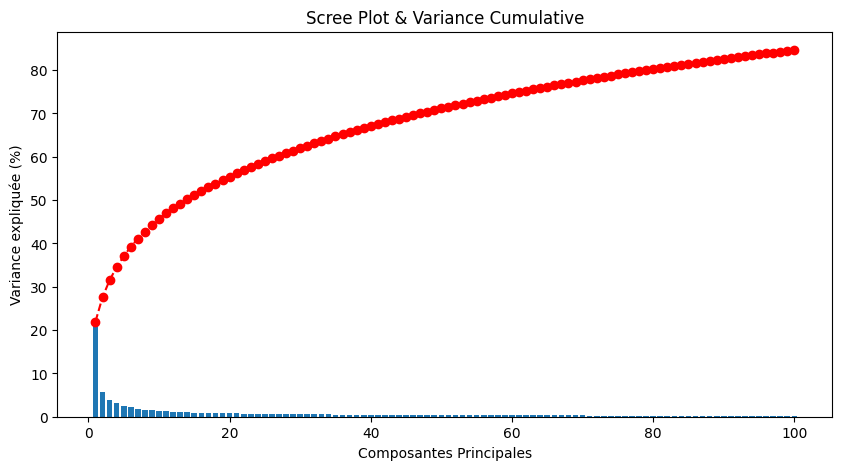

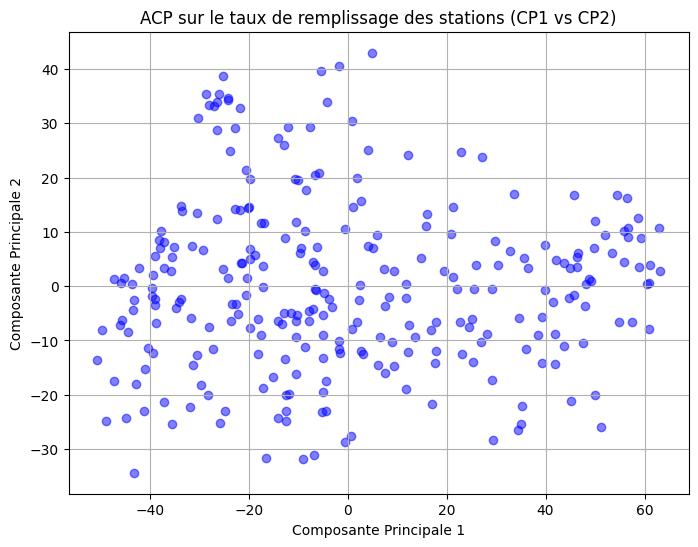

Variance expliquée par CP1 : 21.95%
Variance expliquée par CP2 : 5.64%


In [21]:

# Drop the 'Heures' column if it exists
if "Heures" in xhour_paris.columns:
    df = xhour_paris.drop(columns=["Heures"])

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# Apply PCA
n_components = 100
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled.T)

# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# 1. Scree Plot
plt.figure(figsize=(10, 5))
plt.bar(range(1, n_components + 1), explained_variance * 100)
plt.plot(range(1, n_components + 1), cumulative_variance * 100, marker='o', color='red', linestyle='--')
plt.xlabel('Composantes Principales')
plt.ylabel('Variance expliquée (%)')
plt.title('Scree Plot & Variance Cumulative')
plt.show()

# 2. Improved Scatter Plot of the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, c='blue')
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.title("ACP sur le taux de remplissage des stations (CP1 vs CP2)")
plt.grid(True)
plt.show()

# 3. Display variance explained by first two components
print(f"Variance expliquée par CP1 : {explained_variance[0]*100:.2f}%")
print(f"Variance expliquée par CP2 : {explained_variance[1]*100:.2f}%")


In [22]:


# Supprimer la colonne 'Heures' si elle existe
if "Heures" in xhour_paris.columns:
    df = xhour_paris.drop(columns=["Heures"])

# Vérifier si les colonnes représentent les stations
station_names = df.columns  # Si chaque colonne correspond à une station

# Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# Appliquer l'ACP sur les colonnes (donc après transposition)
n_components = 2
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled.T)  # Note l'utilisation de .T ici

# Convertir en DataFrame pour Plotly
pca_df = pd.DataFrame(X_pca[:, :2], columns=['CP1', 'CP2'])
pca_df['Nom_station'] = station_names  # Utilisation correcte des noms de colonnes

# Visualiser avec Plotly
fig = px.scatter(
    pca_df,
    x='CP1',
    y='CP2',
    hover_name='Nom_station',  # Le nom de la station s'affichera au survol
    title="ACP Interactif sur le taux de remplissage des stations",
    width=800,
    height=600
)
fig.show()
explained_variance = pca.explained_variance_ratio_
print("Variance expliquée par composante:", explained_variance)
print("Variance cumulée:", np.cumsum(explained_variance))

Variance expliquée par composante: [0.21953003 0.05635947]
Variance cumulée: [0.21953003 0.2758895 ]


In [23]:
xhour_paris

,Heures,00906-gare-de-lest,01001-ile-de-la-cite-pont-neuf,01007-etienne-marcel,01019-saint-honore-vendome,02004-reaumur-montorgueil,02012-quatre-septembre,05006-saint-jacques-soufflot,05009-square-viviani,05012-ulm-lhomond,...,42702-leclerc-kremlin-bicetre,42706-salengro-kremlin-bicetre,43001-paris-1-vincennes,43002-lagny-vincennes,43004-montreuil-vincennes,43006-minimes-vincennes,43007-vorges-vincennes,44101-place-mongolfier-saint-maurice,44102-verdun-saint-maurice,jour
0,1,0.050000,0.687500,0.500000,0.214286,0.823529,0.095238,0.000000,0.875000,0.000000,...,0.050000,0.566667,0.283560,0.680000,0.760000,0.714286,1.000000,0.604167,1.000000,1
1,2,0.000000,0.687500,0.200000,0.214286,0.941176,0.095238,0.000000,0.500000,0.000000,...,0.050000,0.533333,0.272727,0.720000,0.720000,0.714286,1.000000,0.604167,1.000000,1
2,3,0.000000,0.687500,0.200000,0.214286,0.941176,0.095238,0.076923,0.500000,0.000000,...,0.050000,0.500000,0.272727,0.760000,0.800000,0.714286,1.000000,0.604167,1.000000,1
3,4,0.000000,0.687500,0.200000,0.214286,1.000000,0.095238,0.000000,0.500000,0.000000,...,0.050000,0.500000,0.272727,0.760000,0.800000,0.714286,1.000000,0.604167,1.000000,1
4,5,0.000000,0.687500,0.200000,0.214286,1.000000,0.095238,0.000000,0.500000,0.000000,...,0.050000,0.500000,0.272727,0.760000,0.800000,0.714286,1.000000,0.604167,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4412,4413,0.880927,0.599821,0.950000,0.120663,0.609718,0.023810,0.000000,0.442783,0.213936,...,0.074771,0.355772,0.090909,0.081588,0.171349,0.215201,0.391046,0.919898,0.632312,184
4413,4414,0.788912,0.625000,0.857791,0.092069,0.506600,0.000000,0.000000,0.312500,0.244625,...,0.127291,0.607395,0.045455,0.149568,0.275465,0.149942,0.426856,0.952340,0.808819,184
4414,4415,0.693783,0.242585,0.668730,0.085096,0.403482,0.000000,0.000000,0.175801,0.219740,...,0.057124,0.830843,0.045455,0.222453,0.663613,0.201125,0.325191,0.979167,0.953349,184
4415,4416,0.549875,0.190586,0.413652,0.134235,0.300364,0.000000,0.000000,0.132035,0.053189,...,0.119322,0.992581,0.041527,0.470913,0.831934,0.250000,0.286721,0.979167,0.920000,184


In [24]:
from sklearn.cluster import KMeans

n_clusters = 4  # À ajuster selon votre besoin
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
pca_df['cluster'] = kmeans.fit_predict(X_pca[:, :2])

# Visualiser les clusters
fig = px.scatter(
    pca_df, 
    x='CP1', 
    y='CP2', 
    color='cluster',
    hover_name='Nom_station',
    title="Groupes de stations avec comportements similaires",
    width=800, 
    height=600
)
fig.show()

In [25]:
xhour_paris.head(15)

,Heures,00906-gare-de-lest,01001-ile-de-la-cite-pont-neuf,01007-etienne-marcel,01019-saint-honore-vendome,02004-reaumur-montorgueil,02012-quatre-septembre,05006-saint-jacques-soufflot,05009-square-viviani,05012-ulm-lhomond,...,42702-leclerc-kremlin-bicetre,42706-salengro-kremlin-bicetre,43001-paris-1-vincennes,43002-lagny-vincennes,43004-montreuil-vincennes,43006-minimes-vincennes,43007-vorges-vincennes,44101-place-mongolfier-saint-maurice,44102-verdun-saint-maurice,jour
0,1,0.050000,0.687500,0.500000,0.214286,0.823529,0.095238,0.000000,0.875000,0.000000,...,0.050000,0.566667,0.283560,0.680000,0.760000,0.714286,1.000000,0.604167,1.000000,1
1,2,0.000000,0.687500,0.200000,0.214286,0.941176,0.095238,0.000000,0.500000,0.000000,...,0.050000,0.533333,0.272727,0.720000,0.720000,0.714286,1.000000,0.604167,1.000000,1
2,3,0.000000,0.687500,0.200000,0.214286,0.941176,0.095238,0.076923,0.500000,0.000000,...,0.050000,0.500000,0.272727,0.760000,0.800000,0.714286,1.000000,0.604167,1.000000,1
3,4,0.000000,0.687500,0.200000,0.214286,1.000000,0.095238,0.000000,0.500000,0.000000,...,0.050000,0.500000,0.272727,0.760000,0.800000,0.714286,1.000000,0.604167,1.000000,1
4,5,0.000000,0.687500,0.200000,0.214286,1.000000,0.095238,0.000000,0.500000,0.000000,...,0.050000,0.500000,0.272727,0.760000,0.800000,0.714286,1.000000,0.604167,1.000000,1
5,6,0.000000,0.687500,0.200000,0.214286,1.000000,0.095238,0.000000,0.500000,0.000000,...,0.050000,0.466667,0.272727,0.720000,0.800000,0.714286,1.000000,0.604167,1.000000,1
6,7,0.000000,0.687500,0.300000,0.285714,1.000000,0.095238,0.000000,0.562500,0.000000,...,0.050000,0.466667,0.272727,0.720000,0.760000,0.714286,1.000000,0.604167,1.000000,1
7,8,0.014334,0.812500,0.292619,0.357143,1.000000,0.095238,0.000000,0.600901,0.066667,...,0.000000,0.466667,0.227273,0.719376,0.640000,0.714286,0.960000,0.604167,0.927408,1
8,9,0.097026,0.937500,0.271821,0.357143,0.933029,0.295699,0.769231,0.750000,0.133333,...,0.049130,0.366667,0.063561,0.775841,0.541057,0.655833,0.880000,0.604167,0.840000,1
9,10,0.029539,0.974095,0.800000,0.928571,0.695149,0.762842,0.758841,0.829037,0.133333,...,0.100000,0.066667,0.188912,1.000000,0.360000,0.659559,0.639749,0.642568,0.840000,1


In [26]:
# Créer un calendrier à partir de l'information que l'index 0 est un lundi à minuit
import pandas as pd
import numpy as np

# Créer une colonne jour de la semaine (0=lundi, 6=dimanche)
total_hours = 4417
days_passed = np.floor(np.arange(total_hours) / 24)  # Nombre de jours écoulés
day_of_week = (days_passed % 7).astype(int)  # Jour de la semaine (0=lundi, 6=dimanche)

# Créer une colonne heure du jour (0=minuit, 23=23h)
hour_of_day = np.arange(total_hours) % 24

# Ajouter ces informations au DataFrame
xhour_paris['day_of_week'] = day_of_week
xhour_paris['hour_of_day'] = hour_of_day
xhour_paris['is_weekend'] = (day_of_week >= 5)  # True pour samedi (5) et dimanche (6)

# Séparer les données weekday/weekend
weekday_data = xhour_paris[~xhour_paris['is_weekend']].drop(columns=['day_of_week', 'hour_of_day', 'is_weekend'])
weekend_data = xhour_paris[xhour_paris['is_weekend']].drop(columns=['day_of_week', 'hour_of_day', 'is_weekend'])

# Fonction pour appliquer l'ACP et le clustering
def apply_pca_and_cluster(data, title_prefix):
    # Supprimer la colonne Heures si nécessaire
    if "Heures" in data.columns:
        df = data.drop(columns=["Heures"])
    else:
        df = data.copy()
    
    # Standardiser les données
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)
    
    # Appliquer l'ACP sur les stations
    from sklearn.decomposition import PCA
    n_components = 10
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled.T)  # Transposer pour avoir les stations en lignes
    
    # Afficher la variance expliquée
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    print(f"{title_prefix} - Variance expliquée par composante: {explained_variance[:5]}")
    print(f"{title_prefix} - Variance cumulée: {cumulative_variance[:5]}")
    
    # Clusteriser les stations
    from sklearn.cluster import KMeans
    n_clusters = 4
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_pca[:, :5])  # Utiliser 5 composantes
    
    # Créer un DataFrame pour la visualisation
    pca_df = pd.DataFrame(X_pca[:, :2], columns=['CP1', 'CP2'])
    pca_df['Nom_station'] = df.columns
    pca_df['cluster'] = clusters
    
    # Visualiser avec Plotly
    import plotly.express as px
    fig = px.scatter(
        pca_df, 
        x='CP1', 
        y='CP2', 
        color='cluster',
        hover_name='Nom_station',
        title=f"{title_prefix} - Groupes de stations avec comportements similaires",
        width=900, 
        height=700
    )
    
    return fig, pca, pca_df, kmeans

# Appliquer aux deux ensembles de données
weekday_fig, weekday_pca, weekday_pca_df, weekday_kmeans = apply_pca_and_cluster(
    weekday_data, "Jours de semaine"
)
weekday_fig.show()

weekend_fig, weekend_pca, weekend_pca_df, weekend_kmeans = apply_pca_and_cluster(
    weekend_data, "Weekend"
)
weekend_fig.show()

Jours de semaine - Variance expliquée par composante: [0.2570367  0.05563015 0.03599759 0.03320303 0.02266723]
Jours de semaine - Variance cumulée: [0.2570367  0.31266685 0.34866444 0.38186747 0.4045347 ]


Weekend - Variance expliquée par composante: [0.10803825 0.07585835 0.0536103  0.04092436 0.03390436]
Weekend - Variance cumulée: [0.10803825 0.1838966  0.23750691 0.27843127 0.31233562]


In [27]:
comparison_df = pd.DataFrame({
    'Nom_station': weekday_pca_df['Nom_station'],
    'Cluster_Semaine': weekday_pca_df['cluster'],
    'Cluster_Weekend': weekend_pca_df['cluster']
})

# Identifier les stations qui changent de cluster
comparison_df['Change_Cluster'] = comparison_df['Cluster_Semaine'] != comparison_df['Cluster_Weekend']
changing_stations = comparison_df[comparison_df['Change_Cluster']]

print(f"Nombre de stations qui changent de cluster: {len(changing_stations)} sur {len(comparison_df)}")
print("\nExemples de stations avec comportement différent semaine/weekend:")
print(changing_stations.head(10))

# Créer une matrice de transition
transition_matrix = pd.crosstab(
    comparison_df['Cluster_Semaine'], 
    comparison_df['Cluster_Weekend'],
    rownames=['Semaine'], 
    colnames=['Weekend']
)
print("\nMatrice de transition entre clusters semaine → weekend:")
print(transition_matrix)

Nombre de stations qui changent de cluster: 181 sur 275

Exemples de stations avec comportement différent semaine/weekend:
                      Nom_station  Cluster_Semaine  Cluster_Weekend  \
0              00906-gare-de-lest                1                3   
1  01001-ile-de-la-cite-pont-neuf                2                1   
2            01007-etienne-marcel                2                1   
3      01019-saint-honore-vendome                2                1   
4       02004-reaumur-montorgueil                2                1   
5          02012-quatre-septembre                2                1   
6    05006-saint-jacques-soufflot                2                1   
7            05009-square-viviani                2                1   
8               05012-ulm-lhomond                2                1   
9          05022-cardinal-lemoine                1                3   

   Change_Cluster  
0            True  
1            True  
2            True  
3            Tr

In [28]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Supposons que vous avez déjà:
# - data_paris: votre jeu de données original
# - xhour_paris: vos données temporelles par station

# 1. Préparation des données pour l'ACP
def prepare_pca_data(df):
    if "Heures" in df.columns:
        df_clean = df.drop(columns=["Heures"])
    else:
        df_clean = df.copy()
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_clean)
    
    pca = PCA(n_components=10)
    X_pca = pca.fit_transform(X_scaled.T)  # Transposer pour avoir les stations en ligne
    
    # Clusterisation
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_pca[:, :5])
    
    # Créer DataFrame pour visualisation
    pca_df = pd.DataFrame(X_pca[:, :2], columns=['CP1', 'CP2'])
    pca_df['nom_station'] = df_clean.columns
    pca_df['cluster'] = clusters
    
    return pca_df, pca.explained_variance_ratio_

# Préparer les données ACP
pca_results, explained_variance = prepare_pca_data(xhour_paris)

# 2. Préparation des données pour la carte
# Calculer le taux moyen de remplissage global par station
station_avg = data_paris.groupby(['nom_station', 'latitude', 'longitude'])['taux_remplissage'].mean().reset_index()
station_avg.rename(columns={'taux_remplissage': 'taux_moy'}, inplace=True)

# 3. Fusion des données ACP avec les coordonnées géographiques
pca_with_coords = pd.merge(pca_results, station_avg[['nom_station', 'latitude', 'longitude', 'taux_moy']], 
                           on='nom_station', how='left')

# 4. Création de l'application Dash
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Analyse des Stations Vélib à Paris"),
    
    # Container pour les deux graphiques
    html.Div([
        # Graphique ACP à gauche
        html.Div([
            html.H3(f"ACP des Stations (CP1: {explained_variance[0]:.2%}, CP2: {explained_variance[1]:.2%})"),
            dcc.Graph(
                id='acp-graph',
                figure=px.scatter(
                    pca_with_coords, x='CP1', y='CP2',
                    color='cluster', hover_name='nom_station',
                    title="Cliquez sur une station pour voir sa position sur la carte"
                ),
                style={'height': '80vh'}
            ),
        ], style={'width': '48%', 'display': 'inline-block', 'vertical-align': 'top'}),
        
        # Carte à droite
        html.Div([
            html.H3("Localisation des Stations (Taux Moyen de Remplissage)"),
            dcc.Graph(
                id='map-graph',
                style={'height': '80vh'}
            )
        ], style={'width': '48%', 'display': 'inline-block', 'vertical-align': 'top', 'margin-left': '2%'})
    ]),
])

# Callback pour mettre à jour la carte quand on clique sur un point dans l'ACP
@app.callback(
    Output('map-graph', 'figure'),
    Input('acp-graph', 'clickData')
)
def update_map(clickData):
    # Créer la carte de base avec toutes les stations
    fig = px.scatter_mapbox(
        station_avg, lat='latitude', lon='longitude',
        color='taux_moy', size='taux_moy',
        hover_name='nom_station',
        color_continuous_scale=["red", "orange"],
        mapbox_style='open-street-map',
        title="Taux de remplissage moyen des stations"
    )
    
    # Si une station est sélectionnée, l'accentuer sur la carte
    if clickData:
        point_index = clickData['points'][0]['pointIndex']
        selected_station = pca_with_coords.iloc[point_index]['nom_station']
        
        selected_station_info = station_avg[station_avg['nom_station'] == selected_station]
        
        if not selected_station_info.empty:
            # Ajouter un marqueur plus grand et visible pour la station sélectionnée
            fig.add_trace(
                px.scatter_mapbox(
                    selected_station_info,
                    lat='latitude', lon='longitude',
                    hover_name='nom_station',
                    size=[20],  # Taille fixe plus grande
                    color_discrete_sequence=["blue"]  # Couleur différente
                ).data[0]
            )
            
            # Centrer la carte sur la station sélectionnée
            fig.update_layout(
                mapbox=dict(
                    center=dict(
                        lat=selected_station_info.iloc[0]['latitude'],
                        lon=selected_station_info.iloc[0]['longitude']
                    ),
                    zoom=15
                )
            )
    
    return fig

if __name__ == '__main__':
    app.run(debug=True,port = 9223)

C:\Users\maysttro\AppData\Local\Temp\ipykernel_45624\1896441577.py:90: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [29]:
import dash
from dash import dcc, html
import plotly.express as px
import pandas as pd

# Supposons que pca_with_coords contient déjà toutes les données nécessaires
# avec les colonnes: nom_station, latitude, longitude, cluster, taux_moy, CP1, CP2

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Analyse des Stations Vélib à Paris"),
    
    # Deux graphiques côte à côte
    html.Div([
        # ACP à gauche
        html.Div([
            html.H3("ACP des Stations"),
            dcc.Graph(
                id='acp-graph',
                figure=px.scatter(
                    pca_with_coords, x='CP1', y='CP2',
                    color='cluster', hover_name='nom_station'
                )
            )
        ], style={'width': '48%', 'display': 'inline-block'}),
        
        # Carte à droite (avec coloration par cluster immédiate)
        html.Div([
            html.H3("Carte des Stations par Cluster"),
            dcc.Graph(
                id='map-graph',
                figure=px.scatter_mapbox(
                    pca_with_coords, 
                    lat='latitude', 
                    lon='longitude',
                    color='cluster',  # Coloration par cluster
                    hover_name='nom_station',
                    mapbox_style='open-street-map'
                )
            )
        ], style={'width': '48%', 'display': 'inline-block', 'margin-left': '2%'})
    ])
])

if __name__ == '__main__':
    app.run(debug=True, port = 8021)

C:\Users\maysttro\AppData\Local\Temp\ipykernel_45624\3265302089.py:33: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



# Interpretation CP1 et CP2 : 

On commence Par les station en bleu et surtout la station Quatre Septembre

![Les Stations en bleu](newplotquatreseptembreACP.png)

![Texte alternatif](qyatreseptembremap.png)

On remarque que la Station quatre septembre en ACP se situent dans les extrimités de CP1 avec les stations chaussee-dantin et provence et si on regarde dans notre carte géographique on remarque que les stations se situent en proximité dans la région 2 e arrondissement ou il y a Opéra et Gare de Paris Saint Lazare 

![Les Stations en bleu](QuatreSpetembre.png)

On remarque dans la carte géographique il y a le Palais Garnier et aussi que place de l'opéra.
On peut dire que l'extrimité positif de CP1 présente Les stations touristiques 

# ACP AVEC DATAFRAME DES HEURES MAIS MANUELLEMENT

In [30]:
xhour_paris_test = xhour_paris.copy()
xhour_paris_test.head()

,Heures,00906-gare-de-lest,01001-ile-de-la-cite-pont-neuf,01007-etienne-marcel,01019-saint-honore-vendome,02004-reaumur-montorgueil,02012-quatre-septembre,05006-saint-jacques-soufflot,05009-square-viviani,05012-ulm-lhomond,...,43002-lagny-vincennes,43004-montreuil-vincennes,43006-minimes-vincennes,43007-vorges-vincennes,44101-place-mongolfier-saint-maurice,44102-verdun-saint-maurice,jour,day_of_week,hour_of_day,is_weekend
0,1,0.05,0.6875,0.5,0.214286,0.823529,0.095238,0.000000,0.875,0.0,...,0.68,0.76,0.714286,1.0,0.604167,1.0,1,0,0,False
1,2,0.00,0.6875,0.2,0.214286,0.941176,0.095238,0.000000,0.500,0.0,...,0.72,0.72,0.714286,1.0,0.604167,1.0,1,0,1,False
2,3,0.00,0.6875,0.2,0.214286,0.941176,0.095238,0.076923,0.500,0.0,...,0.76,0.80,0.714286,1.0,0.604167,1.0,1,0,2,False
3,4,0.00,0.6875,0.2,0.214286,1.000000,0.095238,0.000000,0.500,0.0,...,0.76,0.80,0.714286,1.0,0.604167,1.0,1,0,3,False
4,5,0.00,0.6875,0.2,0.214286,1.000000,0.095238,0.000000,0.500,0.0,...,0.76,0.80,0.714286,1.0,0.604167,1.0,1,0,4,False


In [31]:
xhour_paris_test = xhour_paris_test.drop(columns=['Heures'])

In [32]:
for station in xhour_paris.columns[1:] :
    vecteur_station = xhour_paris[station].apply(np.array)
    mean = xhour_paris[station].mean()
    std = xhour_paris[station].std()
    vecteur_normalised = vecteur_station.apply(lambda x: (x - mean)/std)
    xhour_paris_test[station] = vecteur_normalised

In [33]:
matrice_cov_hour = xhour_paris_test.cov()

In [34]:
matrice_cov_hour = matrice_cov_hour.values
print(matrice_cov_hour)

[[ 1.00000000e+00  3.03429039e-02  8.36926334e-02 ...  1.19081812e-01
   1.65947252e-01  7.81122863e-02]
 [ 3.03429039e-02  1.00000000e+00  6.48262316e-01 ... -5.02581758e-02
   4.30799454e-01  5.40742888e-03]
 [ 8.36926334e-02  6.48262316e-01  1.00000000e+00 ...  1.53852237e-02
   5.53811884e-01  7.14987062e-02]
 ...
 [ 1.19081812e-01 -5.02581758e-02  1.53852237e-02 ...  1.00000000e+00
   1.82286614e-04  7.90490018e-01]
 [ 1.65947252e-01  4.30799454e-01  5.53811884e-01 ...  1.82286614e-04
   1.00000000e+00  2.35986326e-04]
 [ 7.81122863e-02  5.40742888e-03  7.14987062e-02 ...  7.90490018e-01
   2.35986326e-04  1.00000000e+00]]


In [35]:
X_test = xhour_paris.copy()
X_test = X_test.drop(columns=['Heures','jour','day_of_week','hour_of_day','is_weekend'])
Matrice_X =X_test.values


In [36]:
X_test

,00906-gare-de-lest,01001-ile-de-la-cite-pont-neuf,01007-etienne-marcel,01019-saint-honore-vendome,02004-reaumur-montorgueil,02012-quatre-septembre,05006-saint-jacques-soufflot,05009-square-viviani,05012-ulm-lhomond,05022-cardinal-lemoine,...,42701-gide-le-kremlin-bicetre,42702-leclerc-kremlin-bicetre,42706-salengro-kremlin-bicetre,43001-paris-1-vincennes,43002-lagny-vincennes,43004-montreuil-vincennes,43006-minimes-vincennes,43007-vorges-vincennes,44101-place-mongolfier-saint-maurice,44102-verdun-saint-maurice
0,0.050000,0.687500,0.500000,0.214286,0.823529,0.095238,0.000000,0.875000,0.000000,0.588235,...,0.066667,0.050000,0.566667,0.283560,0.680000,0.760000,0.714286,1.000000,0.604167,1.000000
1,0.000000,0.687500,0.200000,0.214286,0.941176,0.095238,0.000000,0.500000,0.000000,0.705882,...,0.066667,0.050000,0.533333,0.272727,0.720000,0.720000,0.714286,1.000000,0.604167,1.000000
2,0.000000,0.687500,0.200000,0.214286,0.941176,0.095238,0.076923,0.500000,0.000000,0.647059,...,0.066667,0.050000,0.500000,0.272727,0.760000,0.800000,0.714286,1.000000,0.604167,1.000000
3,0.000000,0.687500,0.200000,0.214286,1.000000,0.095238,0.000000,0.500000,0.000000,0.588235,...,0.066667,0.050000,0.500000,0.272727,0.760000,0.800000,0.714286,1.000000,0.604167,1.000000
4,0.000000,0.687500,0.200000,0.214286,1.000000,0.095238,0.000000,0.500000,0.000000,0.588235,...,0.066667,0.050000,0.500000,0.272727,0.760000,0.800000,0.714286,1.000000,0.604167,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4412,0.880927,0.599821,0.950000,0.120663,0.609718,0.023810,0.000000,0.442783,0.213936,0.005517,...,0.010290,0.074771,0.355772,0.090909,0.081588,0.171349,0.215201,0.391046,0.919898,0.632312
4413,0.788912,0.625000,0.857791,0.092069,0.506600,0.000000,0.000000,0.312500,0.244625,0.016396,...,0.016131,0.127291,0.607395,0.045455,0.149568,0.275465,0.149942,0.426856,0.952340,0.808819
4414,0.693783,0.242585,0.668730,0.085096,0.403482,0.000000,0.000000,0.175801,0.219740,0.000000,...,0.021972,0.057124,0.830843,0.045455,0.222453,0.663613,0.201125,0.325191,0.979167,0.953349
4415,0.549875,0.190586,0.413652,0.134235,0.300364,0.000000,0.000000,0.132035,0.053189,0.161542,...,0.027814,0.119322,0.992581,0.041527,0.470913,0.831934,0.250000,0.286721,0.979167,0.920000


In [37]:
Matrice_X = Matrice_X[:-1].astype(float)

In [38]:
X_mean = np.mean(Matrice_X, axis=0)

In [39]:
X_std = np.std(Matrice_X, axis=0, ddof=1)

In [40]:
X_standardized = (Matrice_X - X_mean) / X_std


In [41]:
Cov_X = np.cov(X_standardized.T , rowvar=False)
Cov_X

array([[ 1.31932206e+00,  1.27007642e+00,  1.23895111e+00, ...,
        -3.07682221e-02, -4.02047430e-02, -2.26223649e-02],
       [ 1.27007642e+00,  1.42356288e+00,  1.38371388e+00, ...,
        -8.24730356e-03, -1.84376044e-02,  1.00332912e-03],
       [ 1.23895111e+00,  1.38371388e+00,  1.52582319e+00, ...,
        -3.40443981e-02, -5.23147311e-02, -3.48591123e-02],
       ...,
       [-3.07682221e-02, -8.24730356e-03, -3.40443981e-02, ...,
         9.00784797e-01,  8.15696646e-01,  7.40132992e-01],
       [-4.02047430e-02, -1.84376044e-02, -5.23147311e-02, ...,
         8.15696646e-01,  9.46702128e-01,  9.23539127e-01],
       [-2.26223649e-02,  1.00332912e-03, -3.48591123e-02, ...,
         7.40132992e-01,  9.23539127e-01,  1.03943861e+00]])

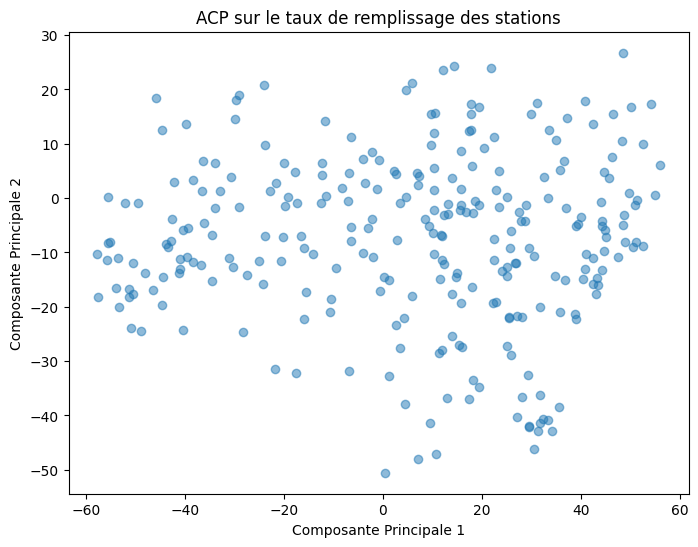

Variance expliquée par CP1 : 21.95%
Variance expliquée par CP2 : 5.64%


In [42]:
# On commence l'ACP
eigenvalues, eigenvectors = np.linalg.eigh(Cov_X)

# Trier par ordre décroissant des valeurs propres
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]
k = 2 
top_eigenvectors = eigenvectors[:, :k]
scores_man = X_standardized.T @ top_eigenvectors
variance_expliquee = eigenvalues / np.sum(eigenvalues)
plt.figure(figsize=(8, 6))
plt.scatter(scores_man[:, 0], scores_man[:, 1], alpha=0.5)

plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.title("ACP sur le taux de remplissage des stations")
plt.show()

# Variance expliquée par chaque composante
explained_variance = pca.explained_variance_ratio_
print(f"Variance expliquée par CP1 : {explained_variance[0]*100:.2f}%")
print(f"Variance expliquée par CP2 : {explained_variance[1]*100:.2f}%")

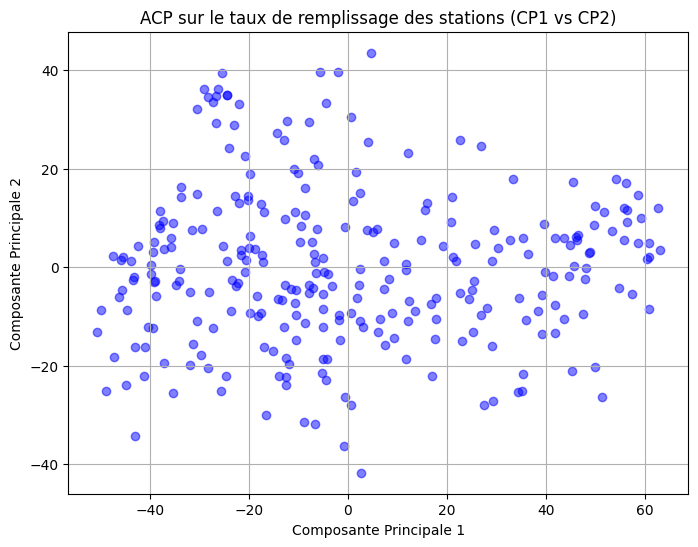

Variance expliquée par CP1 : 21.73%
Variance expliquée par CP2 : 5.86%


In [43]:
if "Heures" in xhour_paris.columns:
    df = xhour_paris.drop(columns=["Heures"])

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# Apply PCA
n_components = 100
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled.T)

# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)


plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, c='blue')
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.title("ACP sur le taux de remplissage des stations (CP1 vs CP2)")
plt.grid(True)
plt.show()

# 3. Display variance explained by first two components
print(f"Variance expliquée par CP1 : {explained_variance[0]*100:.2f}%")
print(f"Variance expliquée par CP2 : {explained_variance[1]*100:.2f}%")

In [44]:
vect10 = scores_man[:,1]/ np.linalg.norm(scores_man[:,1])

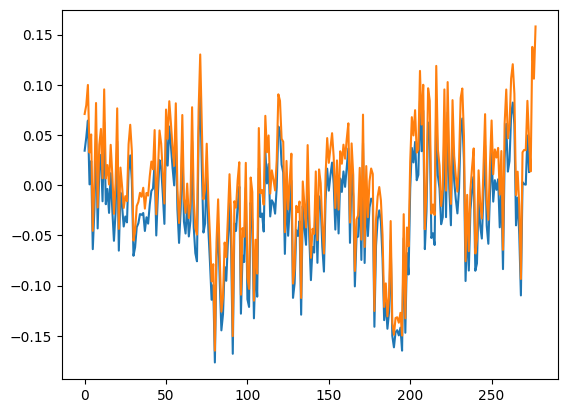

In [45]:
plt.plot(vect10)
plt.plot(-X_pca[:,1]/np.linalg.norm(X_pca[:,1]))

# ACP AVEC LE TABLEAU DE VECTEURS (JOURS)

In [46]:
stations = xjour_paris_normalisé.columns[1:]

# Convertir chaque station en une matrice (jours x 24 heures)
matrices_stations = {
    station: np.vstack(xjour_paris_normalisé[station].values)
    for station in stations
}

In [47]:
for station in xjour_paris_normalisé.columns[1:]:
    xjour_paris_normalisé[station] = xjour_paris_normalisé[station].apply(np.array)
stations = xjour_paris_normalisé.columns[1:]

# Créer un dictionnaire de matrices (jours x 24 heures) pour chaque station
matrices_stations = {}
for station in stations:
    # Convertir les vecteurs en une matrice 2D (jours x heures)
    matrices_stations[station] = np.vstack(xjour_paris_normalisé[station].values)
    

In [48]:
stat1 = xjour_paris_normalisé['00906-gare-de-lest'].values
result = np.dot(stat1,stat1)/185

In [49]:
def produit_scalaire_colonnes(df, colonne1, colonne2):
    somme = 0
    for index in range(len(df)):
        vecteur1 = df.at[index, colonne1]
        vecteur2 = df.at[index, colonne2]
        produit = np.dot(vecteur1, vecteur2)
        somme += produit
    
    return somme/185/24

In [50]:
xjour_paris_normalisé.at[0,'00906-gare-de-lest']

array([-0.56189773, -0.74508537, -0.71042988, -0.7020923 , -0.70876154,
       -0.75951293, -0.88644039, -1.11532449, -0.64495035, -0.67765841,
       -0.7383109 , -0.28953358, -0.68333462, -0.048091  , -0.20946728,
       -0.53615141, -0.53271679, -0.46159241,  1.28060889,  1.00788072,
        1.48106333,  1.033645  ,  0.35071555,  0.72645321])

In [51]:
def produit_scalaire_stations(df,colonne1,colonne2):
    somme = 0
    for i in range (len(df[colonne1])):
        vect1 = df.at[i,colonne1]
        vect2 = df.at[i,colonne2]
        somme += vect1 @ vect2
    return somme/185/24

In [52]:
testtest = produit_scalaire_stations(xjour_paris_normalisé,'00906-gare-de-lest','00906-gare-de-lest')
print(testtest)

1.0000000000000004


In [53]:
cov_matrix_jour = np.zeros((274, 274))
for i, stat_i in enumerate(xjour_paris_normalisé.columns[1:]):
    produit_scalaire = 0
    for j,stat_j in enumerate(xjour_paris_normalisé.columns[1:]):
        cov_matrix_jour[i,j] = produit_scalaire_stations(xjour_paris_normalisé,stat_i,stat_j)

In [54]:
eigenvalues_jours, eigenvectors_jours = np.linalg.eigh(cov_matrix_jour)

sorted_indices = np.argsort(eigenvalues_jours)[::-1]
eigenvalues_jours = eigenvalues_jours[sorted_indices]
eigenvectors_jours = eigenvectors_jours[:, sorted_indices]

In [ ]:
n_stations = 274
valeurs_propres, vecteurs_propres = np.linalg.eigh(cov_matrix_jour)

# Trier les valeurs propres et vecteurs propres par ordre décroissant
idx = valeurs_propres.argsort()[::-1]
valeurs_propres = valeurs_propres[idx]
vecteurs_propres = vecteurs_propres[:, idx]

# Calcul de la variance expliquée par chaque composante
variance_totale = np.sum(valeurs_propres)
variance_expliquee = [(val / variance_totale) * 100 for val in valeurs_propres]
variance_cumulee = np.cumsum(variance_expliquee)

# Afficher les résultats
print("\nLes 10 premières valeurs propres :")
print(valeurs_propres[:10])

print("\nPourcentage de variance expliquée par les 10 premières composantes :")
print([f"{v:.2f}%" for v in variance_expliquee[:10]])

print("\nPourcentage cumulé de variance expliquée :")
print([f"{v:.2f}%" for v in variance_cumulee[:10]])

# Calcul des composantes principales pour chaque station
# Nous utilisons les k premiers vecteurs propres (par exemple k=2)
k = 2
composantes_principales = np.zeros((n_stations, k))

for i in range(n_stations):
    station_i = f"Station_{i}"
    for j in range(k):
        # Projection sur le vecteur propre j
        composantes_principales[i, j] = sum(
            vecteurs_propres[s, j] * cov_matrix_jour[i, s] 
            for s in range(n_stations)
        )


Les 10 premières valeurs propres :
[41.23938049 18.55424259 11.57369349  8.58955412  6.60530203  6.29538427
  5.25960662  4.38842619  3.94062788  3.79217846]

Pourcentage de variance expliquée par les 10 premières composantes :
['15.05%', '6.77%', '4.22%', '3.13%', '2.41%', '2.30%', '1.92%', '1.60%', '1.44%', '1.38%']

Pourcentage cumulé de variance expliquée :
['15.05%', '21.82%', '26.05%', '29.18%', '31.59%', '33.89%', '35.81%', '37.41%', '38.85%', '40.23%']


In [56]:
df_test = xhour_paris.drop(columns='jour')

In [57]:
df_test.head()

,Heures,00906-gare-de-lest,01001-ile-de-la-cite-pont-neuf,01007-etienne-marcel,01019-saint-honore-vendome,02004-reaumur-montorgueil,02012-quatre-septembre,05006-saint-jacques-soufflot,05009-square-viviani,05012-ulm-lhomond,...,43001-paris-1-vincennes,43002-lagny-vincennes,43004-montreuil-vincennes,43006-minimes-vincennes,43007-vorges-vincennes,44101-place-mongolfier-saint-maurice,44102-verdun-saint-maurice,day_of_week,hour_of_day,is_weekend
0,1,0.05,0.6875,0.5,0.214286,0.823529,0.095238,0.000000,0.875,0.0,...,0.283560,0.68,0.76,0.714286,1.0,0.604167,1.0,0,0,False
1,2,0.00,0.6875,0.2,0.214286,0.941176,0.095238,0.000000,0.500,0.0,...,0.272727,0.72,0.72,0.714286,1.0,0.604167,1.0,0,1,False
2,3,0.00,0.6875,0.2,0.214286,0.941176,0.095238,0.076923,0.500,0.0,...,0.272727,0.76,0.80,0.714286,1.0,0.604167,1.0,0,2,False
3,4,0.00,0.6875,0.2,0.214286,1.000000,0.095238,0.000000,0.500,0.0,...,0.272727,0.76,0.80,0.714286,1.0,0.604167,1.0,0,3,False
4,5,0.00,0.6875,0.2,0.214286,1.000000,0.095238,0.000000,0.500,0.0,...,0.272727,0.76,0.80,0.714286,1.0,0.604167,1.0,0,4,False


In [58]:
df_test['jour'] = df_test['Heures'] // 24

In [59]:
df_test.head(25)

,Heures,00906-gare-de-lest,01001-ile-de-la-cite-pont-neuf,01007-etienne-marcel,01019-saint-honore-vendome,02004-reaumur-montorgueil,02012-quatre-septembre,05006-saint-jacques-soufflot,05009-square-viviani,05012-ulm-lhomond,...,43002-lagny-vincennes,43004-montreuil-vincennes,43006-minimes-vincennes,43007-vorges-vincennes,44101-place-mongolfier-saint-maurice,44102-verdun-saint-maurice,day_of_week,hour_of_day,is_weekend,jour
0,1,0.050000,0.687500,0.500000,0.214286,0.823529,0.095238,0.000000,0.875000,0.000000,...,0.680000,0.760000,0.714286,1.000000,0.604167,1.000000,0,0,False,0
1,2,0.000000,0.687500,0.200000,0.214286,0.941176,0.095238,0.000000,0.500000,0.000000,...,0.720000,0.720000,0.714286,1.000000,0.604167,1.000000,0,1,False,0
2,3,0.000000,0.687500,0.200000,0.214286,0.941176,0.095238,0.076923,0.500000,0.000000,...,0.760000,0.800000,0.714286,1.000000,0.604167,1.000000,0,2,False,0
3,4,0.000000,0.687500,0.200000,0.214286,1.000000,0.095238,0.000000,0.500000,0.000000,...,0.760000,0.800000,0.714286,1.000000,0.604167,1.000000,0,3,False,0
4,5,0.000000,0.687500,0.200000,0.214286,1.000000,0.095238,0.000000,0.500000,0.000000,...,0.760000,0.800000,0.714286,1.000000,0.604167,1.000000,0,4,False,0
5,6,0.000000,0.687500,0.200000,0.214286,1.000000,0.095238,0.000000,0.500000,0.000000,...,0.720000,0.800000,0.714286,1.000000,0.604167,1.000000,0,5,False,0
6,7,0.000000,0.687500,0.300000,0.285714,1.000000,0.095238,0.000000,0.562500,0.000000,...,0.720000,0.760000,0.714286,1.000000,0.604167,1.000000,0,6,False,0
7,8,0.014334,0.812500,0.292619,0.357143,1.000000,0.095238,0.000000,0.600901,0.066667,...,0.719376,0.640000,0.714286,0.960000,0.604167,0.927408,0,7,False,0
8,9,0.097026,0.937500,0.271821,0.357143,0.933029,0.295699,0.769231,0.750000,0.133333,...,0.775841,0.541057,0.655833,0.880000,0.604167,0.840000,0,8,False,0
9,10,0.029539,0.974095,0.800000,0.928571,0.695149,0.762842,0.758841,0.829037,0.133333,...,1.000000,0.360000,0.659559,0.639749,0.642568,0.840000,0,9,False,0


In [60]:
df_test['day_of_week'] = df_test['jour'] % 7

In [61]:
df_test['day_type'] = np.where(df_test['day_of_week'] < 5, 'weekday', 'weekend')

In [62]:
station_columns = df_test.columns.drop(['Heures', 'jour', 'day_of_week', 'day_type'])
X = df_test[station_columns]

# Standardisation (moyenne=0, écart-type=1)
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [63]:
pca = PCA(n_components=2)
scores_test = pca.fit_transform(X_std)

# Créer un DataFrame pour les résultats
df_pca = pd.DataFrame(scores_test, columns=['PC1', 'PC2'])
df_pca['day_type'] = df_test['day_type']

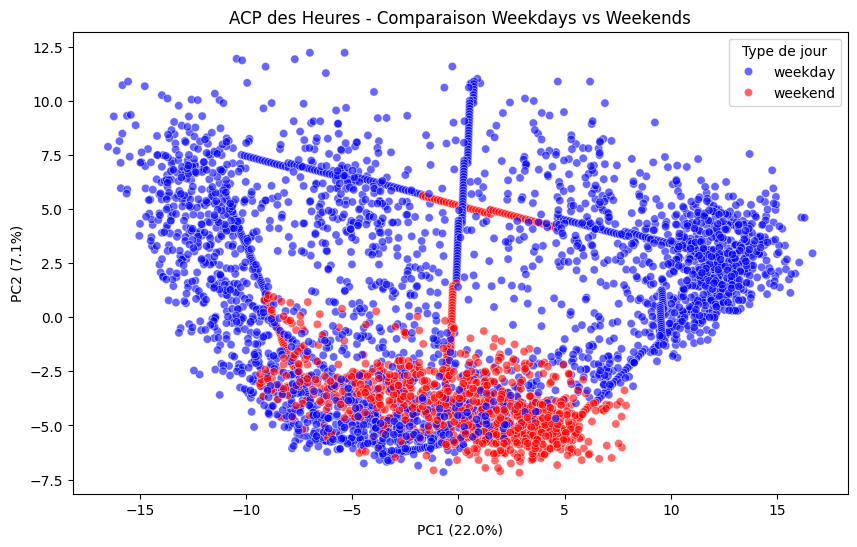

In [64]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_pca,
    x='PC1',
    y='PC2',
    hue='day_type',
    palette={'weekday': 'blue', 'weekend': 'red'},
    alpha=0.6
)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("ACP des Heures - Comparaison Weekdays vs Weekends")
plt.legend(title='Type de jour')
plt.show()

In [65]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=station_columns)

# Stations les plus influentes sur PC1
print("Top 5 Stations - PC1 :\n", loadings['PC1'].abs().sort_values(ascending=False).head(5))

# Stations les plus influentes sur PC2
print("\nTop 5 Stations - PC2 :\n", loadings['PC2'].abs().sort_values(ascending=False).head(5))

Top 5 Stations - PC1 :
 09039-chaussee-dantin           0.109619
15039-charles-vallin            0.107981
02012-quatre-septembre          0.107666
01019-saint-honore-vendome      0.107485
15038-place-adolphe-cherioux    0.105982
Name: PC1, dtype: float64

Top 5 Stations - PC2 :
 13041-porte-divry            0.169514
20115-porte-de-bagnolet      0.155403
14018-porte-dorleans         0.153249
20106-mairie-du-20eme        0.150787
20111-lisle-adam-pyrenees    0.139589
Name: PC2, dtype: float64


In [66]:
xjour_paris.head()

,jour,00906-gare-de-lest,01001-ile-de-la-cite-pont-neuf,01007-etienne-marcel,01019-saint-honore-vendome,02004-reaumur-montorgueil,02012-quatre-septembre,05006-saint-jacques-soufflot,05009-square-viviani,05012-ulm-lhomond,...,42701-gide-le-kremlin-bicetre,42702-leclerc-kremlin-bicetre,42706-salengro-kremlin-bicetre,43001-paris-1-vincennes,43002-lagny-vincennes,43004-montreuil-vincennes,43006-minimes-vincennes,43007-vorges-vincennes,44101-place-mongolfier-saint-maurice,44102-verdun-saint-maurice
0,1,"[0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0143336...","[0.6875, 0.6875, 0.6875, 0.6875, 0.6875, 0.687...","[0.5, 0.2, 0.2, 0.2, 0.2, 0.2, 0.3, 0.29261938...","[0.214285714285714, 0.214285714285714, 0.21428...","[0.823529411764706, 0.941176470588235, 0.94117...","[0.0952380952380952, 0.0952380952380952, 0.095...","[0.0, 0.0, 0.0769230769230769, 0.0, 0.0, 0.0, ...","[0.875, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5625, 0.600...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06666666...",...,"[0.0666666666666667, 0.0666666666666667, 0.066...","[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...","[0.566666666666667, 0.533333333333333, 0.5, 0....","[0.283559706316556, 0.272727272727273, 0.27272...","[0.68, 0.72, 0.76, 0.76, 0.76, 0.72, 0.72, 0.7...","[0.76, 0.72, 0.8, 0.8, 0.8, 0.8, 0.76, 0.64, 0...","[0.714285714285714, 0.714285714285714, 0.71428...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96, 0.88...","[0.604166666666667, 0.604166666666667, 0.60416...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92740765..."
1,2,"[0.25, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1528800...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125...","[0.291795025720747, 0.247359099265589, 0.21427...","[0.142857142857143, 0.142857142857143, 0.14285...","[0.705882352941177, 0.764705882352941, 0.76470...","[0.0238095238095238, 0.0238095238095238, 0.023...","[0.0769230769230769, 0.149284439687258, 0.0998...","[0.875, 0.875, 0.875, 0.875, 0.463825712574809...","[0.0666666666666667, 0.192795388735137, 0.1534...",...,"[0.0666666666666667, 0.0666666666666667, 0.066...","[0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.087803807954...","[0.366666666666667, 0.466666666666667, 0.46666...","[0.181818181818182, 0.136363636363636, 0.13636...","[0.32, 0.44, 0.44, 0.44, 0.44, 0.4, 0.36, 0.28...","[0.894611278188264, 0.96, 0.96, 0.945938410602...","[0.821428571428571, 0.821428571428571, 0.82142...","[0.72, 0.72, 0.72, 0.72, 0.72, 0.7247784946098...","[0.791666666666667, 0.791666666666667, 0.79166...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.88,..."
2,3,"[0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.1, 0.057...","[0.1875, 0.0, 0.0, 0.0, 0.0625, 0.0625, 0.0625...","[0.623890557919295, 0.55, 0.461226562491659, 0...","[0.0, 0.0, 0.0, 0.0714285714285714, 0.07142857...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0588235294117...","[0.0, 0.0, 0.0, 0.0238095238095238, 0.02380952...","[0.153846153846154, 0.0, 0.0, 0.07692307692307...","[0.9375, 0.631390493710095, 0.5625, 0.625, 0.5...","[0.0666666666666667, 0.133333333333333, 0.1333...",...,"[0.0333333333333333, 0.0333333333333333, 0.066...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.1,...","[1.0, 0.965435185274152, 0.966666666666667, 1....","[0.0454545454545455, 0.181818181818182, 0.1363...","[0.444557021990113, 0.537336972714252, 0.52, 0...","[0.96, 0.92, 0.92, 1.0, 1.0, 1.0, 0.96, 0.88, ...","[0.971155030807868, 0.964285714285714, 1.0, 1....","[0.64, 0.64, 0.72, 0.72, 0.72, 0.72, 0.72, 0.7...","[0.895833333333333, 0.895833333333333, 0.89583...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995875001201..."
3,4,"[0.0870533873720172, 0.0858652411112125, 0.084...","[0.524271188208385, 0.526497316690627, 0.52872...","[0.866198777864988, 0.858467508846562, 0.85073...","[0.990754769913528, 0.989906785290316, 0.98905...","[0.874723348870135, 0.874025153646605, 0.87332...","[0.853368573367422, 0.842039396583171, 0.83071...","[0.267948636726006, 0.264293610303211, 0.26063...","[0.840630202424848, 0.831725894058756, 0.82282...","[0.589247233284144, 0.582120801811711, 0.57499...",...,"[0.0506015031468343, 0.0521867759623

In [71]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Chargement des fichiers
x_hour_paris = pd.read_csv("X_hour_paris.csv", index_col=0)
distance_paris = pd.read_csv("distance_paris.csv", index_col=0)
x_hour_toulouse = pd.read_csv("X_hour_toulouse.csv", index_col=0)
distance_toulouse = pd.read_csv("distance_toulouse.csv", index_col=0)

# Calculer directement les matrices de corrélation
corr_paris = x_hour_paris.corr()
corr_toulouse = x_hour_toulouse.corr()

# Application Dash
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Corrélation vs Distance entre Stations", style={'textAlign': 'center'}),
    
    html.Div([
        html.Div([
            html.Label("Sélectionnez une ville:"),
            dcc.RadioItems(
                id='city-selector',
                options=[
                    {'label': 'Paris', 'value': 'paris'},
                    {'label': 'Toulouse', 'value': 'toulouse'}
                ],
                value='paris',
                inline=True
            )
        ], style={'marginBottom': 20}),
        
        html.Div([
            html.Label("Sélectionnez une station:"),
            dcc.Dropdown(
                id='station-dropdown', 
                clearable=False,
                style={'width': '100%'}
            )
        ], style={'marginBottom': 20}),
    ], style={'width': '80%', 'margin': '0 auto'}),
    
    dcc.Graph(id='correlation-graph'),
    
    html.Div([
        html.Div(id='stats-output')
    ], style={'width': '80%', 'margin': '20px auto'})
])

@app.callback(
    Output('station-dropdown', 'options'),
    Output('station-dropdown', 'value'),
    Input('city-selector', 'value')
)
def update_dropdown(city):
    if city == 'paris':
        stations = x_hour_paris.columns
    else:
        stations = x_hour_toulouse.columns
    
    options = [{'label': st, 'value': st} for st in stations]
    return options, stations[0]

@app.callback(
    [Output('correlation-graph', 'figure'),
     Output('stats-output', 'children')],
    [Input('city-selector', 'value'),
     Input('station-dropdown', 'value')]
)
def update_graph(city, selected_station):
    if city == 'paris':
        distance_df = distance_paris
        corr_df = corr_paris
    else:
        distance_df = distance_toulouse
        corr_df = corr_toulouse
    
    if selected_station in distance_df.index and selected_station in corr_df.columns:
        # Extraire les distances et corrélations pour la station sélectionnée
        distances = distance_df.loc[selected_station]
        correlations = corr_df.loc[selected_station]
        
        # Fusionner les deux séries
        common_stations = distances.index.intersection(correlations.index)
        
        # Exclure la station elle-même (corrélation = 1.0)
        common_stations = [s for s in common_stations if s != selected_station]
        
        if len(common_stations) > 0:
            # Créer un DataFrame avec les données alignées
            data = pd.DataFrame({
                'Station': common_stations,
                'Distance': distances[common_stations].values,
                'Corrélation': correlations[common_stations].values
            })
            
            # Trier par distance
            data = data.sort_values('Distance')
            
            # Calculer la corrélation entre distance et corrélation
            distance_corr = np.corrcoef(data['Distance'], data['Corrélation'])[0, 1]
            
            # Créer la figure
            fig = go.Figure()
            
            # Ajouter les points avec colorscale basée sur la corrélation
            fig.add_trace(go.Scatter(
                x=data['Distance'],
                y=data['Corrélation'],
                mode='markers',
                marker=dict(
                    size=10,
                    color=data['Corrélation'],
                    colorscale='Viridis',
                    showscale=True,
                    colorbar=dict(title="Corrélation"),
                    opacity=0.7
                ),
                text=data['Station'],
                hovertemplate='<b>%{text}</b><br>Distance: %{x:.2f} km<br>Corrélation: %{y:.4f}<extra></extra>'
            ))
            
            # Ajouter une ligne de tendance si au moins 2 points
            if len(data) >= 2:
                z = np.polyfit(data['Distance'], data['Corrélation'], 1)
                p = np.poly1d(z)
                x_range = np.linspace(data['Distance'].min(), data['Distance'].max(), 100)
                
                fig.add_trace(go.Scatter(
                    x=x_range,
                    y=p(x_range),
                    mode='lines',
                    line=dict(color='red', dash='dash', width=2),
                    name='Tendance'
                ))
            
            # Mise en forme du graphique
            fig.update_layout(
                title=f"Corrélation vs Distance pour la station: {selected_station} ({city.capitalize()})",
                xaxis_title="Distance (km)",
                yaxis_title="Coefficient de corrélation",
                template="plotly_white",
                hovermode='closest',
                height=600
            )
            
            # Ajouter des statistiques
            stats = html.Div([
                html.H3("Statistiques", style={'textAlign': 'center'}),
                html.Table([
                    html.Tr([html.Td("Nombre de stations comparées:"), html.Td(f"{len(data)}")]),
                    html.Tr([html.Td("Distance moyenne:"), html.Td(f"{data['Distance'].mean():.2f} km")]),
                    html.Tr([html.Td("Distance médiane:"), html.Td(f"{data['Distance'].median():.2f} km")]),
                    html.Tr([html.Td("Corrélation moyenne:"), html.Td(f"{data['Corrélation'].mean():.4f}")]),
                    html.Tr([html.Td("Corrélation médiane:"), html.Td(f"{data['Corrélation'].median():.4f}")]),
                    html.Tr([html.Td("Corrélation entre distance et corrélation:"), html.Td(f"{distance_corr:.4f}")]),
                    html.Tr([html.Td("Coefficient directeur:"), html.Td(f"{z[0]:.6f}" if len(data) >= 2 else "N/A")]),
                    html.Tr([html.Td("Ordonnée à l'origine:"), html.Td(f"{z[1]:.4f}" if len(data) >= 2 else "N/A")])
                ], style={'margin': '0 auto', 'border-collapse': 'collapse', 'width': '100%'})
            ], style={'backgroundColor': '#f9f9f9', 'padding': '15px', 'borderRadius': '5px'})
            
            return fig, stats
        else:
            msg = f"Aucune station commune trouvée pour {selected_station} dans les données"
            return go.Figure(layout={"title": msg}), html.Div(msg)
    else:
        msg = f"Station '{selected_station}' non trouvée dans les données"
        return go.Figure(layout={"title": msg}), html.Div(msg)

if __name__ == '__main__':
    app.run(debug=True, port=7043)

# Prévision

In [72]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objects as go
import plotly.express as px
from dash import Dash, dcc, html, Input, Output, State
import dash_bootstrap_components as dbc

# Chargement des données
df = pd.read_csv("X_hour_paris.csv", index_col=0)  # Remplacez par votre chemin de fichier

# Ajouter des caractéristiques temporelles
df['heure'] = df.index % 24
df['jour'] = (df.index // 24) % 7  # 0 = lundi, 6 = dimanche
df['est_weekend'] = df['jour'].isin([5, 6]).astype(int)  # 1 si samedi ou dimanche

# Création de l'application Dash
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = dbc.Container([
    dbc.Row([
        dbc.Col([
            html.H1("Prévision du Taux de Remplissage des Stations de Vélo", className="text-center my-4"),
            html.Hr()
        ])
    ]),
    
    dbc.Row([
        dbc.Col([
            html.H3("Configuration du modèle"),
            html.Div([
                html.Label("Sélectionnez une station à prédire:"),
                dcc.Dropdown(
                    id='target-station',
                    options=[{'label': col, 'value': col} for col in df.columns if col not in ['heure', 'jour', 'est_weekend']],
                    value=df.columns[0],
                    clearable=False
                )
            ], className="mb-3"),
            
            html.Div([
                html.Label("Sélectionnez le type de modèle:"),
                dcc.RadioItems(
                    id='model-type',
                    options=[
                        {'label': 'Régression linéaire', 'value': 'linear'},
                        {'label': 'Ridge (régularisation L2)', 'value': 'ridge'},
                        {'label': 'Lasso (régularisation L1)', 'value': 'lasso'},
                        {'label': 'Random Forest', 'value': 'rf'}
                    ],
                    value='linear',
                    labelStyle={'display': 'block', 'margin': '5px 0'}
                )
            ], className="mb-3"),
            
            html.Div([
                html.Label("Nombre de stations à utiliser comme prédicteurs:"),
                dcc.Slider(
                    id='n-predictors',
                    min=1,
                    max=10,
                    step=1,
                    value=5,
                    marks={i: str(i) for i in range(0, 11, 2)},
                ),
                html.Div(id='predictor-output')
            ], className="mb-3"),
            
            html.Div([
                html.Label("Inclure les caractéristiques temporelles:"),
                dcc.Checklist(
                    id='temporal-features',
                    options=[
                        {'label': 'Heure du jour', 'value': 'heure'},
                        {'label': 'Jour de la semaine', 'value': 'jour'},
                        {'label': 'Est weekend', 'value': 'est_weekend'}
                    ],
                    value=['heure', 'est_weekend'],
                    labelStyle={'display': 'block', 'margin': '5px 0'}
                )
            ], className="mb-3"),
            
            dbc.Button("Entraîner le modèle", id="train-button", color="primary", className="mt-3 w-100")
        ], width=4),
        
        dbc.Col([
            html.H3("Résultats du modèle"),
            dcc.Loading(
                id="loading-results",
                type="circle",
                children=[
                    html.Div(id='model-stats'),
                    dcc.Graph(id='prediction-graph'),
                    dcc.Graph(id='feature-importance')
                ]
            )
        ], width=8)
    ])
], fluid=True)

@app.callback(
    Output('predictor-output', 'children'),
    Input('n-predictors', 'value')
)
def update_predictor_output(value):
    return f"Nombre de stations prédictives: {value}"

@app.callback(
    [Output('model-stats', 'children'),
     Output('prediction-graph', 'figure'),
     Output('feature-importance', 'figure')],
    Input('train-button', 'n_clicks'),
    [State('target-station', 'value'),
     State('model-type', 'value'),
     State('n-predictors', 'value'),
     State('temporal-features', 'value')],
    prevent_initial_call=True
)
def train_and_evaluate(n_clicks, target_station, model_type, n_predictors, temporal_features):
    if n_clicks is None:
        # Retourner des valeurs par défaut pour éviter l'erreur de callback
        empty_fig = go.Figure()
        empty_fig.update_layout(title="Aucun modèle entraîné")
        return "Aucun modèle entraîné", empty_fig, empty_fig
    
    try:
        # Préparation des données
        # 1. Sélectionner la station cible
        y = df[target_station]
        
        # 2. Calculer la corrélation de toutes les autres stations avec la cible
        station_columns = [col for col in df.columns if col not in ['heure', 'jour', 'est_weekend']]
        correlations = df[station_columns].corrwith(y).sort_values(ascending=False)
        
        # 3. Sélectionner les stations les plus corrélées (excluant la station cible)
        top_correlated = correlations.drop(target_station).head(n_predictors).index.tolist()
        
        # 4. Préparer la matrice des prédicteurs
        X = df[top_correlated].copy()
        
        # 5. Ajouter les caractéristiques temporelles si demandé
        for feature in temporal_features:
            X[feature] = df[feature]
        
        # Ajouter des variables cycliques pour l'heure si présente
        if 'heure' in temporal_features:
            X['heure_sin'] = np.sin(2 * np.pi * df['heure']/24)
            X['heure_cos'] = np.cos(2 * np.pi * df['heure']/24)
        
        # Division en ensembles d'entraînement et de test (80/20)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Sélection et entraînement du modèle
        if model_type == 'linear':
            model = LinearRegression()
            model_name = "Régression linéaire"
        elif model_type == 'ridge':
            model = Ridge(alpha=1.0)
            model_name = "Ridge (L2)"
        elif model_type == 'lasso':
            model = Lasso(alpha=0.1)
            model_name = "Lasso (L1)"
        else:  # Random Forest
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model_name = "Random Forest"
        
        model.fit(X_train, y_train)
        
        # Évaluation du modèle
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # 1. Création des statistiques du modèle
        stats_card = dbc.Card([
            dbc.CardHeader(f"Statistiques du modèle: {model_name}"),
            dbc.CardBody([
                html.P(f"Station cible: {target_station}"),
                html.P(f"Erreur quadratique moyenne (MSE): {mse:.5f}"),
                html.P(f"Coefficient de détermination (R²): {r2:.5f}"),
                html.P(f"Nombre d'observations d'entraînement: {len(X_train)}"),
                html.P(f"Nombre d'observations de test: {len(X_test)}")
            ])
        ])
        
        # 2. Graphique des prédictions
        pred_fig = px.scatter(
            x=y_test.values, y=y_pred,
            title=f"Valeurs prédites vs Valeurs réelles pour {target_station}",
            labels={'x': 'Taux de remplissage réel', 'y': 'Taux de remplissage prédit'}
        )
        
        # Ajouter une ligne de référence y = x
        pred_fig.add_trace(
            go.Scatter(
                x=[y_test.min(), y_test.max()],
                y=[y_test.min(), y_test.max()],
                mode='lines',
                line=dict(color='red', dash='dash'),
                name='y = x'
            )
        )
        
        pred_fig.update_layout(
            template='plotly_white',
            height=400
        )
        
        # 3. Graphique d'importance des caractéristiques
        if model_type in ['linear', 'ridge', 'lasso']:
            # Pour les modèles linéaires, utiliser les coefficients
            importance = pd.DataFrame({
                'feature': X.columns,
                'importance': np.abs(model.coef_) if hasattr(model, 'coef_') else np.zeros(len(X.columns))
            })
        else:
            # Pour Random Forest, utiliser l'importance des caractéristiques
            importance = pd.DataFrame({
                'feature': X.columns,
                'importance': model.feature_importances_
            })
        
        importance = importance.sort_values('importance', ascending=False).head(10)
        
        imp_fig = px.bar(
            importance, x='importance', y='feature', orientation='h',
            title="Importance des caractéristiques",
            labels={'importance': 'Importance', 'feature': 'Caractéristique'},
            height=400
        )
        
        imp_fig.update_layout(template='plotly_white')
        
        return stats_card, pred_fig, imp_fig
        
    except Exception as e:
        # En cas d'erreur, retourner un message d'erreur
        error_msg = html.Div([
            html.H4("Erreur lors de l'entraînement du modèle:"),
            html.P(str(e))
        ])
        
        empty_fig = go.Figure()
        empty_fig.update_layout(title="Erreur lors de l'entraînement du modèle")
        
        return error_msg, empty_fig, empty_fig

if __name__ == '__main__':
    app.run(debug=True, port=8054)

Régression manuelle:
Intercept (β): -0.043872
Coefficients (α):
  22005-de-gaulle-3-neuilly: 0.289069
  08035-narvick: 0.226004
  09039-chaussee-dantin: 0.226446
  09031-provence: 0.182493
  41604-lagny-saint-mande: 0.220533
MSE: 0.018031
R²: 0.856101

Régression sklearn:
Intercept: -0.043872
Coefficients:
  22005-de-gaulle-3-neuilly: 0.289069
  08035-narvick: 0.226004
  09039-chaussee-dantin: 0.226446
  09031-provence: 0.182493
  41604-lagny-saint-mande: 0.220533
MSE: 0.018031
R²: 0.856101


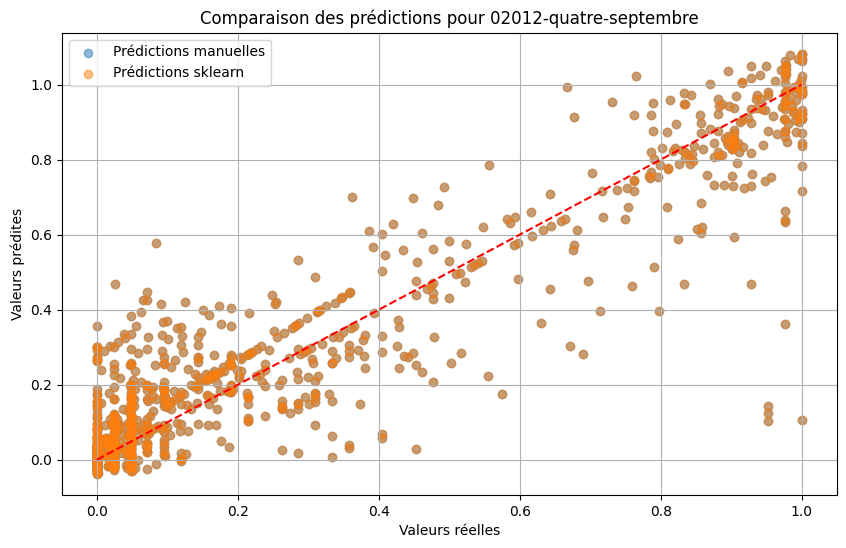


Vérification manuelle de quelques prédictions:
Observation 0:
  Valeur réelle: 0.847997
  Prédiction manuelle: 0.836774
  Prédiction numpy: 0.836774
  Prédiction sklearn: 0.836774
Observation 1:
  Valeur réelle: 0.226491
  Prédiction manuelle: 0.294379
  Prédiction numpy: 0.294379
  Prédiction sklearn: 0.294379
Observation 2:
  Valeur réelle: 0.285714
  Prédiction manuelle: 0.531467
  Prédiction numpy: 0.531467
  Prédiction sklearn: 0.531467
Observation 3:
  Valeur réelle: 0.000000
  Prédiction manuelle: -0.029221
  Prédiction numpy: -0.029221
  Prédiction sklearn: -0.029221
Observation 4:
  Valeur réelle: 0.037668
  Prédiction manuelle: 0.334204
  Prédiction numpy: 0.334204
  Prédiction sklearn: 0.334204


In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Chargez vos données
df = pd.read_csv("X_hour_paris.csv", index_col=0)  # Remplacez par votre chemin de fichier

# 1. Sélectionnez une station cible
target_station = "02012-quatre-septembre"  # Remplacez par votre station d'intérêt
y = df[target_station]

# 2. Sélectionnez les stations les plus corrélées comme prédicteurs
correlations = df.corrwith(y).sort_values(ascending=False)
top_stations = correlations.drop(target_station).head(5).index.tolist()
X = df[top_stations]

# 3. Divisez en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Calculez manuellement les coefficients (alphas) et l'intercept (beta)
# Ajouter une colonne de 1 pour calculer l'intercept
X_train_with_intercept = np.column_stack((np.ones(X_train.shape[0]), X_train))

# Formule pour les moindres carrés ordinaires: β = (X^T X)^(-1) X^T y
beta_manual = np.linalg.inv(X_train_with_intercept.T @ X_train_with_intercept) @ X_train_with_intercept.T @ y_train.values

# Extrayez l'intercept et les coefficients
intercept_manual = beta_manual[0]
alphas_manual = beta_manual[1:]

# 5. Comparez avec sklearn pour vérification
model_sklearn = LinearRegression()
model_sklearn.fit(X_train, y_train)

# 6. Faites des prédictions manuelles
X_test_with_intercept = np.column_stack((np.ones(X_test.shape[0]), X_test))
y_pred_manual = X_test_with_intercept @ beta_manual

# 7. Faites des prédictions avec sklearn
y_pred_sklearn = model_sklearn.predict(X_test)

# 8. Évaluez et comparez les performances
mse_manual = mean_squared_error(y_test, y_pred_manual)
r2_manual = r2_score(y_test, y_pred_manual)

mse_sklearn = mean_squared_error(y_test, y_pred_sklearn)
r2_sklearn = r2_score(y_test, y_pred_sklearn)

# 9. Affichez les résultats
print("Régression manuelle:")
print(f"Intercept (β): {intercept_manual:.6f}")
print("Coefficients (α):")
for station, alpha in zip(top_stations, alphas_manual):
    print(f"  {station}: {alpha:.6f}")
print(f"MSE: {mse_manual:.6f}")
print(f"R²: {r2_manual:.6f}")

print("\nRégression sklearn:")
print(f"Intercept: {model_sklearn.intercept_:.6f}")
print("Coefficients:")
for station, coef in zip(top_stations, model_sklearn.coef_):
    print(f"  {station}: {coef:.6f}")
print(f"MSE: {mse_sklearn:.6f}")
print(f"R²: {r2_sklearn:.6f}")

# 10. Visualisez les prédictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_manual, alpha=0.5, label="Prédictions manuelles")
plt.scatter(y_test, y_pred_sklearn, alpha=0.5, label="Prédictions sklearn")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.title(f"Comparaison des prédictions pour {target_station}")
plt.legend()
plt.grid(True)
plt.show()

# 11. Vérifiez manuellement quelques prédictions
print("\nVérification manuelle de quelques prédictions:")
for i in range(min(5, len(X_test))):
    prediction = intercept_manual
    for j, station in enumerate(top_stations):
        prediction += alphas_manual[j] * X_test.iloc[i][station]
    print(f"Observation {i}:")
    print(f"  Valeur réelle: {y_test.iloc[i]:.6f}")
    print(f"  Prédiction manuelle: {prediction:.6f}")
    print(f"  Prédiction numpy: {y_pred_manual[i]:.6f}")
    print(f"  Prédiction sklearn: {y_pred_sklearn[i]:.6f}")

In [70]:
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Liste des stations (à l'exclusion des colonnes de caractéristiques temporelles)
station_columns = [col for col in df.columns if col not in ['heure', 'jour', 'est_weekend']]

app.layout = dbc.Container([
    dbc.Row([
        dbc.Col([
            html.H1("Comparaison des Valeurs Réelles et Prédites", className="text-center my-4"),
            html.Hr()
        ])
    ]),
    
    dbc.Row([
        dbc.Col([
            html.H4("Sélection de la station"),
            dcc.Dropdown(
                id='station-selector',
                options=[{'label': station, 'value': station} for station in station_columns],
                value=station_columns[0],
                clearable=False
            ),
            
            html.Div([
                html.Label("Nombre de stations prédictives:"),
                dcc.Slider(
                    id='n-predictors',
                    min=3,
                    max=15,
                    step=1,
                    value=5,
                    marks={i: str(i) for i in range(3, 16, 2)},
                ),
                html.Div(id='predictor-output')
            ], className="my-4"),
            
            html.Div([
                html.Label("Inclure les caractéristiques temporelles:"),
                dcc.Checklist(
                    id='temporal-features',
                    options=[
                        {'label': 'Heure du jour', 'value': 'heure'},
                        {'label': 'Jour de la semaine', 'value': 'jour'},
                        {'label': 'Est weekend', 'value': 'est_weekend'}
                    ],
                    value=['heure', 'est_weekend'],
                    inline=True
                )
            ], className="my-4"),
            
            html.Div([
                html.Label("Nombre de points à afficher:"),
                dcc.Slider(
                    id='n-points',
                    min=24,
                    max=240,
                    step=24,
                    value=72,
                    marks={i: str(i) for i in range(24, 241, 48)},
                ),
            ], className="my-4"),
            
            dbc.Button("Générer le graphique", id="generate-button", color="primary", className="mt-3 w-100")
        ], width=4),
        
        dbc.Col([
            dcc.Loading(
                id="loading-graph",
                type="circle",
                children=[
                    dcc.Graph(id='time-series-graph', style={'height': '70vh'}),
                    html.Div(id='model-stats', className="mt-3")
                ]
            )
        ], width=8)
    ])
], fluid=True)

@app.callback(
    Output('predictor-output', 'children'),
    Input('n-predictors', 'value')
)
def update_predictor_output(value):
    return f"Utiliser {value} stations pour la prédiction"

@app.callback(
    [Output('time-series-graph', 'figure'),
     Output('model-stats', 'children')],
    Input('generate-button', 'n_clicks'),
    [Input('station-selector', 'value'),
     Input('n-predictors', 'value'),
     Input('temporal-features', 'value'),
     Input('n-points', 'value')],
    prevent_initial_call=True
)
def update_graph(n_clicks, target_station, n_predictors, temporal_features, n_points):
    # Préparation des données
    y = df[target_station]
    
    # Calcul des corrélations
    station_features = [col for col in df.columns if col not in ['heure', 'jour', 'est_weekend']]
    correlations = df[station_features].corrwith(y).sort_values(ascending=False)
    top_stations = correlations.drop(target_station).head(n_predictors).index.tolist()
    
    # Création des features
    X = df[top_stations].copy()
    for feature in temporal_features:
        X[feature] = df[feature]
    
    # Variables cycliques pour l'heure
    if 'heure' in temporal_features:
        X['heure_sin'] = np.sin(2 * np.pi * df['heure']/24)
        X['heure_cos'] = np.cos(2 * np.pi * df['heure']/24)
        X = X.drop('heure', axis=1)
    
    # Division en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Entraînement du modèle
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Prédiction sur l'ensemble complet
    all_predictions = model.predict(X)
    
    # Calcul des métriques
    y_pred_test = model.predict(X_test)
    mse = np.mean((y_test - y_pred_test)**2)
    r2 = 1 - np.sum((y_test - y_pred_test)**2) / np.sum((y_test - y_test.mean())**2)
    
    # Préparation des données pour le graphique
    # Prendre les n_points derniers points
    end_idx = len(df)
    start_idx = max(0, end_idx - n_points)
    
    time_df = pd.DataFrame({
        'index': df.index[start_idx:end_idx],
        'actual': y.iloc[start_idx:end_idx],
        'predicted': all_predictions[start_idx:end_idx]
    })
    
    # Création du graphique
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
        x=time_df['index'],
        y=time_df['actual'],
        mode='lines',
        name='Valeurs réelles',
        line=dict(color='blue', width=2)
    ))
    
    fig.add_trace(go.Scatter(
        x=time_df['index'],
        y=time_df['predicted'],
        mode='lines',
        name='Valeurs prédites',
        line=dict(color='red', width=2, dash='dash')
    ))
    
    # Mise en forme du graphique
    fig.update_layout(
        title=f"Évolution du taux de remplissage - Station: {target_station}",
        xaxis_title="Temps (heures)",
        yaxis_title="Taux de remplissage",
        template='plotly_white',
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        margin=dict(l=40, r=40, t=60, b=40)
    )
    
    # Mise à jour des axes
    hour_labels = [f"{h}h" for h in range(24)]
    hour_values = time_df['index'] % 24
    
    fig.update_xaxes(
        tickvals=time_df['index'],
        ticktext=[f"{val}" for val in hour_values],
        tickangle=45
    )
    
    # Statistiques du modèle
    stats = dbc.Card([
        dbc.CardHeader("Statistiques du modèle"),
        dbc.CardBody([
            html.Div([
                html.Span("Erreur quadratique moyenne (MSE): ", className="font-weight-bold"),
                html.Span(f"{mse:.5f}")
            ]),
            html.Div([
                html.Span("Coefficient de détermination (R²): ", className="font-weight-bold"),
                html.Span(f"{r2:.5f}")
            ]),
            html.Div([
                html.Span("Stations les plus influentes: ", className="font-weight-bold"),
                html.Ul([html.Li(station) for station in top_stations[:3]])
            ])
        ])
    ])
    
    return fig, stats

if __name__ == '__main__':
    app.run(debug=True, port=8061)